# **Assignment 3**

This notebook contains the solution to parts 2 and 3 of the third assignment in the Practical Data Science course

### **Part 2 - Data Mining**

##### **Task 1 - Data Acquisition and Preprocessing**

In [1]:
# Importing required packages

import zipfile
from google.colab import files, auth
import random
import os
import pandas as pd
import numpy as np
import cv2
from matplotlib import pyplot as plt
from google.colab import drive
from geopy.distance import geodesic
import folium
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from skimage.transform import resize
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import gspread
from gspread_dataframe import get_as_dataframe
from google.auth import default
from googleapiclient.discovery import build
import seaborn as sns
from sklearn.metrics import cohen_kappa_score as kappa
from scipy.spatial import distance
from sklearn.manifold import TSNE
import warnings

# Suppress all warnings
warnings.simplefilter("ignore")

# Setting pandas display
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)
pd.set_option("display.max_colwidth", None)

Upload the Kaggle credentials file to an appropriate place in the colab directory to connect to the Kaggle API

In [ ]:
# Uploading the kaggle.json file
uploaded = files.upload()

# Moving the file to the proper folder
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


Download the dataset

In [ ]:
# Downloading the dataset
!kaggle datasets download -d amaralibey/gsv-cities -p /content

Dataset URL: https://www.kaggle.com/datasets/amaralibey/gsv-cities
License(s): Attribution-NonCommercial-NoDerivatives 4.0 International (CC BY-NC-ND 4.0)
100% 21.8G/21.8G [17:10<00:00, 27.6MB/s]
100% 21.8G/21.8G [17:10<00:00, 22.7MB/s]


Open and get the content of the dataset

In [ ]:
# Opening the dataset
dataset = zipfile.ZipFile("gsv-cities.zip", "r")

# Getting its content
contents = dataset.namelist()

# Showing random content
random.sample(contents, 5)

['Images/Melbourne/Melbourne_0003693_2019_06_313_-37.81784718637054_144.9929754918104_CItnpIPTlMk1FKqsozQ2zg.jpg',
 'Images/London/London_0002061_2017_12_112_51.49595755373376_-0.1489521290078279_YM-jiXA82_IVDQsi3AfMWw.jpg',
 'Images/Rome/Rome_0002784_2012_11_322_41.91140418048341_12.4723748178712_O0N5uuRZr8suZxwMMT_phQ.jpg',
 'Images/Bangkok/Bangkok_0001449_2014_09_406_13.73024729985556_100.5352754635928_HMB1Xk931CbeB-rL4cpNpQ.jpg',
 'Images/Madrid/Madrid_0000879_2013_10_156_40.40905535952091_-3.705467602761993_U34EvPu2sErwCWvrofYZBg.jpg']

It seems that the dataset contains 529.529 paths of csv and jpg files

In [ ]:
# Getting the amount of contents
print("Total paths:", len(contents))

# Checking if the contents refer to file paths
print(
    "Different types of files:", set(content.rsplit(".", 1)[1] for content in contents)
)
print(
    "Number of invalid filepaths:",
    len(list(filter(lambda content: "/" not in content, contents))),
)

Total paths: 529529
Different types of files: {'csv', 'jpg'}
Number of invalid filepaths: 0


There are two main folders which are the 'Images' and 'Dataframes'

In [ ]:
# Getting the unique folders
folders = set(content.split("/", 1)[0] for content in contents)
print(folders)

{'Images', 'Dataframes'}


In [ ]:
# Distinction of folders
dataframes = [content for content in contents if content.startswith("Dataframes")]
images = [content for content in contents if content.startswith("Images")]

Let's start exploring the Dataframes folder

There are 23 csv files correspoding to 23 different cities as shown below

In [ ]:
dataframes

['Dataframes/Bangkok.csv',
 'Dataframes/Barcelona.csv',
 'Dataframes/Boston.csv',
 'Dataframes/Brussels.csv',
 'Dataframes/BuenosAires.csv',
 'Dataframes/Chicago.csv',
 'Dataframes/Lisbon.csv',
 'Dataframes/London.csv',
 'Dataframes/LosAngeles.csv',
 'Dataframes/Madrid.csv',
 'Dataframes/Medellin.csv',
 'Dataframes/Melbourne.csv',
 'Dataframes/MexicoCity.csv',
 'Dataframes/Miami.csv',
 'Dataframes/Minneapolis.csv',
 'Dataframes/OSL.csv',
 'Dataframes/Osaka.csv',
 'Dataframes/PRG.csv',
 'Dataframes/PRS.csv',
 'Dataframes/Phoenix.csv',
 'Dataframes/Rome.csv',
 'Dataframes/TRT.csv',
 'Dataframes/WashingtonDC.csv']

Let's open the first csv file

In [ ]:
# Opening the Bangkok.csv file
cities = pd.read_csv(dataset.open(dataframes[0]))

As we can see there are 8 columns with specific data types as shown below

In [ ]:
# Showing the first 3 rows
display(cities.head(3))

# Getting its columns and data types
data_types = cities.dtypes
display(cities.dtypes)

place_id  year  month  northdeg  city_id        lat         lon  \
0      4213  2011      9       536  Bangkok  13.763345  100.523557   
1      2014  2017      5       610  Bangkok  13.738478  100.498262   
2      3776  2018      8       420  Bangkok  13.758588  100.518943   

                   panoid  
0  QKQ1Vdq9y_N2mQHwoKmn0Q  
1  m8wCJkVpRtM_FVn26Vl9yA  
2  uYbCbiXZYC5I6GlUvKQ80Q

place_id      int64
year          int64
month         int64
northdeg      int64
city_id      object
lat         float64
lon         float64
panoid       object
dtype: object

Create a dataframe containing all the csv files which have the same format and structure

In [ ]:
# Iterating through the csv files
for dataframe in range(1, len(dataframes)):

    # Opening the csv file
    csv_df = pd.read_csv(dataset.open(dataframes[dataframe]))

    # Checking if it has the same format
    if data_types.equals(csv_df.dtypes):

        # Concatenating
        cities = pd.concat([cities, csv_df])

    else:

        print("The current csv file has a different structure and format!")
        break

cities.sample(5)

place_id  year  month  northdeg city_id        lat        lon  \
47115      8269  2014      7       131  London  51.526233  -0.139963   
28345      1593  2017      8       354     PRS  48.833302   2.361360   
16814      1596  2019      4        12    Rome  41.894217  12.491435   
9953       7172  2011      8       198  Boston  42.383036 -71.103903   
17034      1070  2015      8       470     PRS  48.819176   2.451869   

                       panoid  
47115  DXRH8iv93XZi5sO3rwDnww  
28345  e44Z1NC1_iZFjyO8LPRzRw  
16814  j-kgoOTyM4_c-QlqOCumLg  
9953   yKuqOio9IvJ5jIzhFk1myA  
17034  KsgxWVcno37aMJ80LvwGDQ

There are 23 unique cities and 529.506 rows in total

In [ ]:
display(len(cities))
display(cities["city_id"].unique())

529506

array(['Bangkok', 'Barcelona', 'Boston', 'Brussels', 'BuenosAires',
       'Chicago', 'Lisbon', 'London', 'LosAngeles', 'Madrid', 'Medellin',
       'Melbourne', 'MexicoCity', 'Miami', 'Minneapolis', 'OSL', 'Osaka',
       'PRG', 'PRS', 'Phoenix', 'Rome', 'TRT', 'WashingtonDC'],
      dtype=object)

There are not duplicate entries

In [ ]:
# Checking for duplicates
cities[cities.duplicated()]

Empty DataFrame
Columns: [place_id, year, month, northdeg, city_id, lat, lon, panoid]
Index: []

Each city contains many unique places, but the number of entries in each of them is much larger, meaning that some places appear more than once in the dataset. This can be seen in the diagram below.

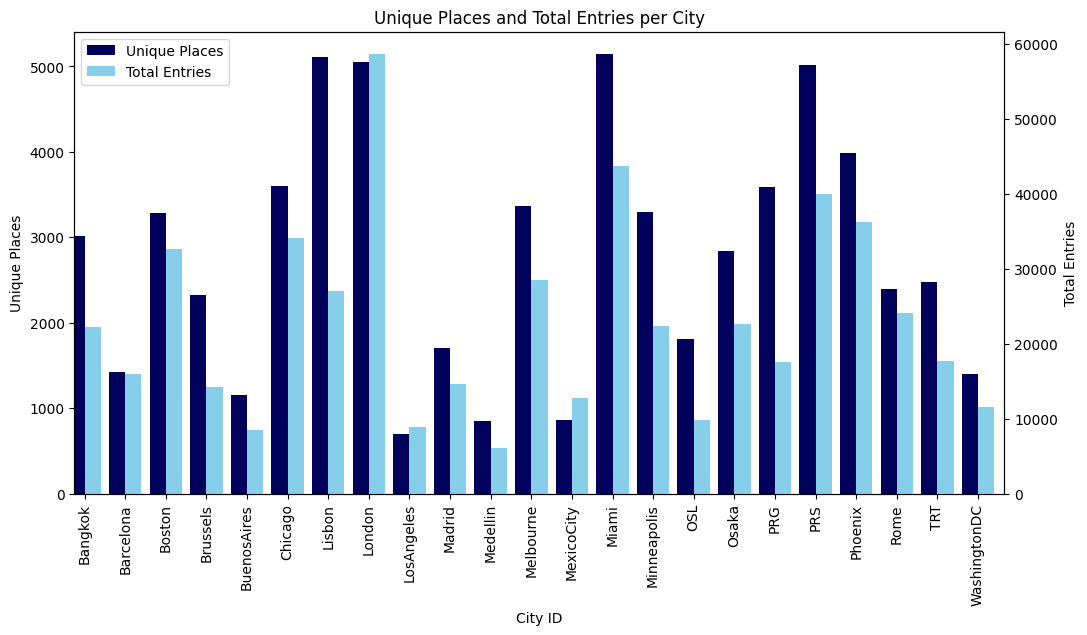

In [ ]:
# Getting the unique places and total entries per city
cities_places_entries = cities.groupby("city_id").agg(
    unique_places=("place_id", "nunique"), total_entries=("place_id", "count")
)

# Create a figure and a single subplot
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot the first type of bars
cities_places_entries["unique_places"].plot(
    kind="bar", color="#00015B", ax=ax1, position=1, width=0.4, label="Unique Places"
)
ax1.set_ylabel("Unique Places")
ax1.set_title("Unique Places and Total Entries per City")

# Create a second type of bars
ax2 = ax1.twinx()
cities_places_entries["total_entries"].plot(
    kind="bar", color="skyblue", ax=ax2, position=0, width=0.4, label="Total Entries"
)
ax2.set_ylabel("Total Entries")

# Set x label
ax1.set_xlabel("City ID")

# Create a single legend for both axes
handles, labels = [], []
for ax in [ax1, ax2]:
    for handle, label in zip(*ax.get_legend_handles_labels()):
        handles.append(handle)
        labels.append(label)
ax1.legend(handles, labels, loc="upper left")

plt.show()

Below, we can see that the lowest frequency of places in the dataset is 2 while the highest is 40.

In [ ]:
# Getting the frequencies of places
places_frequency = (
    cities.groupby(["city_id", "place_id"], as_index=False)
    .agg(frequency=("panoid", "count"))
    .sort_values(by="frequency", ignore_index=True)
)

print(
    f"The lowest frequency of places in the dataset is: {places_frequency['frequency'][0]}"
)
print(
    f"The highest frequency of places in the dataset is: {places_frequency['frequency'][len(places_frequency) - 1]}"
)

The lowest frequency of places in the dataset is: 2
The highest frequency of places in the dataset is: 40


Let's explore now the 'Image' folder

There are 529.506 file paths under the 'Image' folder, which is the number of lines in the final dataframe of cities. Also, each file path contains two backslashes where this means there are subfolders under the 'Image' folder and then under them are all the images included.

In [ ]:
# Creating a dataframe with the 'Image' paths
images_df = pd.DataFrame(images, columns=["image_path"])

# Getting the amount of file paths under 'Image' folder
print("Total images paths:", len(images_df))

# Chekcing if all the paths contain two backslashes
print(
    "Total paths containing two backslashes:",
    len(images_df[images_df["image_path"].str.count("/") == 2]),
)

# Getting a sample
display(images_df.sample(5))

Total images paths: 529506
Total paths containing two backslashes: 529506


image_path
389742  Images/PRG/PRG_0001546_2019_09_283_50.07322088...
193983  Images/London/London_0006611_2017_03_282_51.51...
134261  Images/Lisbon/Lisbon_0002354_2014_07_304_38.72...
175102  Images/London/London_0002709_2017_08_303_51.49...
127950  Images/Lisbon/Lisbon_0000187_2018_09_329_38.70...

Split the image paths

In [ ]:
# Getting the subfolders and the file names
images_df["city_id"] = images_df["image_path"].apply(
    lambda path: path.split("/", 1)[1].split("/", 1)[0]
)
images_df["image_filename"] = images_df["image_path"].apply(
    lambda path: path.split("/", 1)[1].split("/", 1)[1]
)

# Getting a sample
display(images_df.sample(5))

image_path  city_id  \
313543  Images/Miami/Miami_0005598_2013_05_206_25.7747...    Miami   
100540  Images/Chicago/Chicago_0001709_2017_08_239_41....  Chicago   
128646  Images/Lisbon/Lisbon_0000470_2014_08_291_38.70...   Lisbon   
436426  Images/PRS/PRS_0004532_2013_05_577_48.89549645...      PRS   
182027  Images/London/London_0004139_2019_05_013_51.50...   London   

                                           image_filename  
313543  Miami_0005598_2013_05_206_25.77475840050905_-8...  
100540  Chicago_0001709_2017_08_239_41.85999628235129_...  
128646  Lisbon_0000470_2014_08_291_38.7076373867187_-9...  
436426  PRS_0004532_2013_05_577_48.89549645369844_2.27...  
182027  London_0004139_2019_05_013_51.50579262288817_-...

There are 23 subfolders corresponding to the same cities with the csv files and the final dataframe of cities.

In [ ]:
# Getting the unique subfolders/referenced cities
images_df["city_id"].unique()

array(['Bangkok', 'Barcelona', 'Boston', 'Brussels', 'BuenosAires',
       'Chicago', 'Lisbon', 'London', 'LosAngeles', 'Madrid', 'Medellin',
       'Melbourne', 'MexicoCity', 'Miami', 'Minneapolis', 'OSL', 'Osaka',
       'PRG', 'PRS', 'Phoenix', 'Rome', 'TRT', 'WashingtonDC'],
      dtype=object)

We can observe that the number of images per city is exactly the same as the number of entries for each city in the final 'cities' dataframe. This indicates that each image can refer to a specific row in the 'cities' dataframe. To verify this let us combine both dataframes.

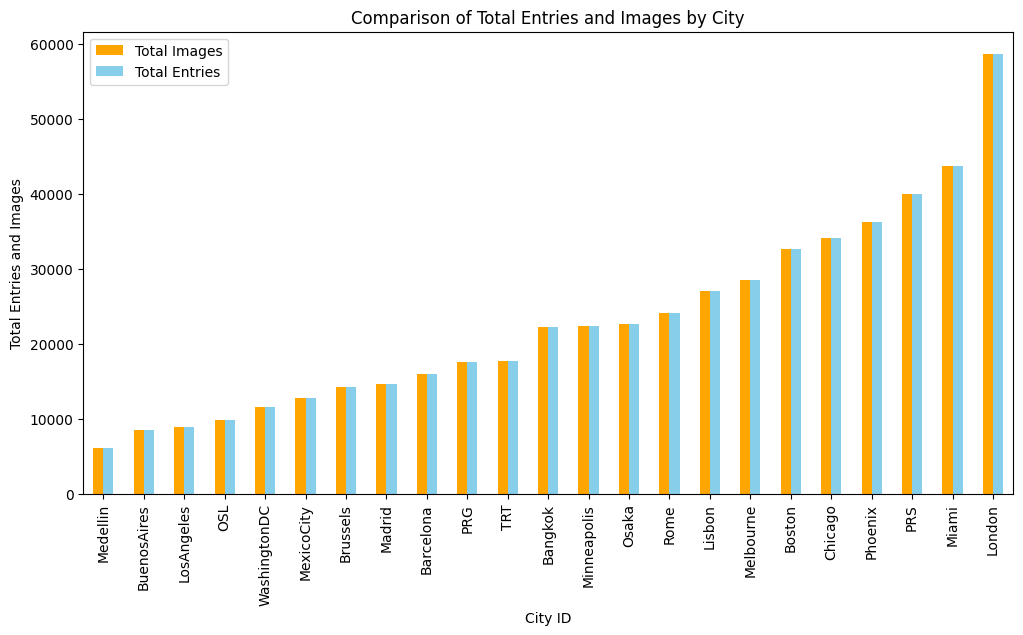

In [ ]:
# Getting the images per city and the corresponding entries
images_per_city = images_df.groupby("city_id").agg(Total=("image_path", "count"))
images_per_city["Total_2"] = cities_places_entries["total_entries"]

# Setting up the plot
ax = images_per_city.sort_values("Total").plot.bar(
    figsize=(12, 6), color=["orange", "skyblue"]
)
ax.set_xlabel("City ID")
ax.set_ylabel("Total Entries and Images")
ax.set_title("Comparison of Total Entries and Images by City")
ax.legend(["Total Images", "Total Entries"])

Having looked at the Kaggle dataset and a [useful notebook](https://www.kaggle.com/code/amaralibey/gsv-cities-visualizing-the-dataset) uploaded by the owner of the dataset which explains how the elements of each row of the 'cities' dataset can be combined to create the associated image name, below is the corresponding function that does this. All the elements in the dataframe are encoded and have a specific size. To ensure consistency, zeros are added to the beginning of any field that does not meet the required width until it reaches it.

In [ ]:
def get_image_filenames(row):
    """
    This function used to find the image filename corresponding to each row of
    'cities' dataframe

    :param row: row of the 'cities' dataframe
    :return: image name
    """

    # Getting the elements of each row and add zeros to the beginning
    # of those that do not have the desired width
    city = row["city_id"]
    place_id = str(row["place_id"]).zfill(7)
    panoid = row["panoid"]
    year = str(row["year"]).zfill(4)
    month = str(row["month"]).zfill(2)
    northdeg = str(row["northdeg"]).zfill(3)
    lat = str(row["lat"])
    lon = str(row["lon"])

    # Getting the filename
    filename = (
        city
        + "_"
        + place_id
        + "_"
        + year
        + "_"
        + month
        + "_"
        + northdeg
        + "_"
        + lat
        + "_"
        + lon
        + "_"
        + panoid
        + ".jpg"
    )

    return filename


# Getting the image filename corresponding to each row of 'cities' dataframe
cities["image_filename"] = cities.apply(get_image_filenames, axis=1)

# Getting a sample
display(cities.sample(5))

place_id  year  month  northdeg   city_id        lat         lon  \
8182       1040  2014      8       277  Brussels  50.841640    4.329527   
9          2551  2017      8       275      Rome  41.907110   12.523751   
34994      3645  2011      4       270   Phoenix  33.459273 -112.029163   
26364      2951  2019      6       409       PRS  48.863292    2.281393   
10358      1791  2014      6        64       TRT  43.705460  -79.470725   

                       panoid  \
8182   Klidihe6IwBERxI-TdZdjQ   
9      YLMQGs_iaUd-El-SgWz8Pw   
34994  cn3Q7fAdxH19xTfDaAF-dg   
26364  EkWaTQ3HgNAGxHDmkTVC8A   
10358  YeByMGZj7OrQg5TJp4v5wQ   

                                          image_filename  
8182   Brussels_0001040_2014_08_277_50.84164019365337...  
9      Rome_0002551_2017_08_275_41.90710987881279_12....  
34994  Phoenix_0003645_2011_04_270_33.45927275410114_...  
26364  PRS_0002951_2019_06_409_48.8632921080842_2.281...  
10358  TRT_0001791_2014_06_064_43.70545975928989_-79....

Combine both dataframes ('cities' and 'images') to get the final filepath for each image per row of the 'cities' dataframe. Since there are no lines without an image file path and no duplicates based on the below results, the above assumption of one image for each line of the "cities" dataframe is true.

In [ ]:
# Merge two dataframes (cities and images)
cities = pd.merge(
    cities,
    images_df[["image_path", "image_filename"]],
    on=["image_filename"],
    how="left",
)

# Getting a sample
display(cities.sample(5))

# Checking if there are not links between cities and images
print("No links: ", len(cities[cities["image_path"].isnull()]))

# Checking for duplicates
print("Duplicate values: ", len(cities[cities["image_path"].duplicated()]))

place_id  year  month  northdeg      city_id        lat        lon  \
93360       1094  2019      7       376  BuenosAires -34.588221 -58.381379   
94013       5451  2016      9       225      Chicago  41.907760 -87.688391   
172248       846  2016      8       223       London  51.489717  -0.092372   
32229        409  2008      5       235    Barcelona  41.367035   2.145901   
354069      3382  2014      5       280          OSL  59.940933  10.752163   

                        panoid  \
93360   h3itN1zuxPQ2zk6DVDru6w   
94013   G5tBI4JXlqksf0xLeeMdsw   
172248  x1bocEAjCEQLRH9iu0ixcQ   
32229   sl1hWP5VAFkPG6fjJvoR7g   
354069  SgPkvPgCXHusu0lEsLEeyw   

                                           image_filename  \
93360   BuenosAires_0001094_2019_07_376_-34.5882212890...   
94013   Chicago_0005451_2016_09_225_41.90775953744201_...   
172248  London_0000846_2016_08_223_51.48971737273044_-...   
32229   Barcelona_0000409_2008_05_235_41.3670353497742...   
354069  OSL_0003382_2014_05_280_59.94093269237381_10.7...   

                                               image_path  
93360   Images/BuenosAires/BuenosAires_0001094_2019_07...  
94013   Images/Chicago/Chicago_0005451_2016_09_225_41....  
172248  Images/London/London_0000846_2016_08_223_51.48...  
32229   Images/Barcelona/Barcelona_0000409_2008_05_235...  
354069  Images/OSL/OSL_0003382_2014_05_280_59.94093269...

No links:  0
Duplicate values:  0


Because the dataset is extremely large, we need to randomly select images by city to create a new dataset that will be easier to manipulate and analyse. To do this, I decided to keep only 10.000 rows by performing a stratified sampling while keeping the distribution of images per city in the original dataset as shown below and earlier.

Text(0.5, 1.0, 'Total Images by City')

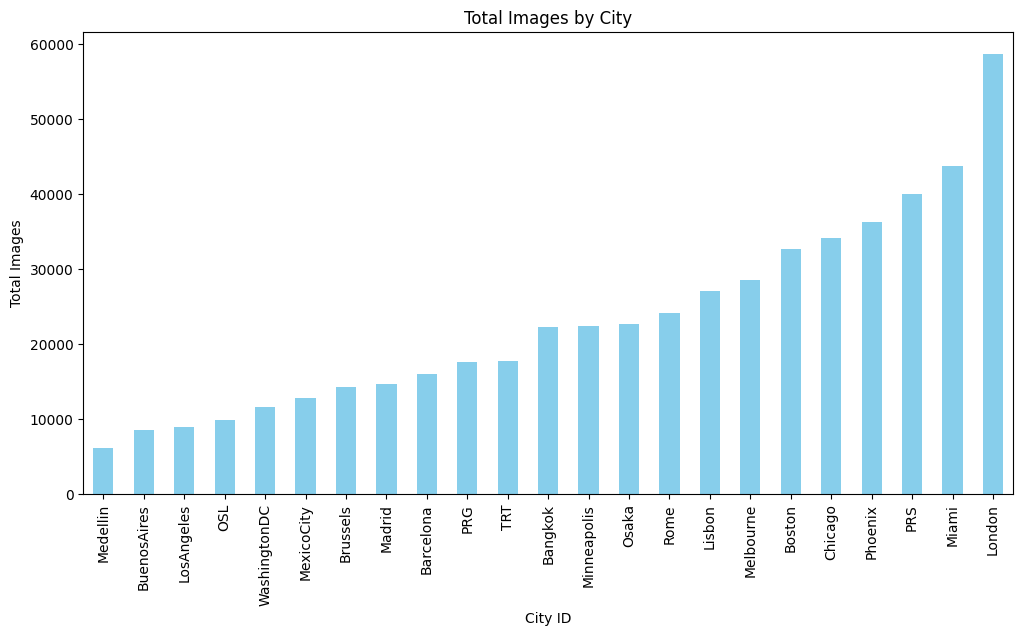

In [ ]:
# Setting up the diagram
ax = (
    cities_places_entries["total_entries"]
    .sort_values()
    .plot.bar(figsize=(12, 6), color=["skyblue"])
)
ax.set_xlabel("City ID")
ax.set_ylabel("Total Images")
ax.set_title("Total Images by City")

In [ ]:
# Setting the final target number of rows
total_rows = 10000

# Calculate proportions of each city in the original dataset
city_proportions = cities["city_id"].value_counts(normalize=True)

# Allocate rows proportionally
city_final_rows = (city_proportions * total_rows).round().astype(int)

print(city_final_rows.sum())

10003


Due to the proportions of the cities the final total number of lines is not exactly 10.000 but more by 3. I exclude three images from the city with the largest appearance, which will not affect so much the distribution of the dataset.

In [ ]:
# Removing three images from the city with the most images
city_final_rows.iloc[0] = city_final_rows.iloc[0] - 3

print(city_final_rows.sum())

10000


Create the new dataset by performing stratified sampling and removing some columns that i decide that i do not want to include in my analysis

In [ ]:
# Performing stratified sampling
final_dataset = (
    cities.groupby("city_id", group_keys=False)
    .apply(
        lambda city: city.sample(
            n=min(len(city), city_final_rows[city.name]), random_state=42
        )
    )
    .reset_index(drop=True)
)

# Removing columns that will be not used in my analysis
final_dataset.drop(columns=["month", "northdeg", "panoid"], inplace=True)

# Getting a random sample
display(final_dataset.sample(5))

place_id  year    city_id        lat         lon  \
3736       241  2008     London  51.487102   -0.112775   
874       1514  2019     Boston  42.334116  -71.025905   
5810      3467  2011      Miami  25.757699  -80.215985   
4816      2880  2019  Melbourne -37.825816  144.961949   
5831      4360  2009      Miami  25.764828  -80.193247   

                                         image_filename  \
3736  London_0000241_2008_06_067_51.48710199453809_-...   
874   Boston_0001514_2019_06_279_42.33411624092876_-...   
5810  Miami_0003467_2011_03_161_25.75769947325594_-8...   
4816  Melbourne_0002880_2019_06_199_-37.825816191526...   
5831  Miami_0004360_2009_05_114_25.76482826103589_-8...   

                                             image_path  
3736  Images/London/London_0000241_2008_06_067_51.48...  
874   Images/Boston/Boston_0001514_2019_06_279_42.33...  
5810  Images/Miami/Miami_0003467_2011_03_161_25.7576...  
4816  Images/Melbourne/Melbourne_0002880_2019_06_199...  
5831  Images/Miami/Miami_0004360_2009_05_114_25.7648...

Define a method to convert the images to RGB format and apply it on the final dataset

In [ ]:
def convert_image(dataset, image_filename):
    """
    This function used to convert the image files to RGB format.

    :param dataset: initial dataset
    :param image_filename: image filename
    :return: image in RGB format
    """

    # Opening the image
    initial_image = dataset.open(image_filename)

    # Reading the binary data of the image.
    binary_data = initial_image.read()
    np_data = np.frombuffer(binary_data, np.uint8)

    # Decoding image
    image = cv2.imdecode(np_data, cv2.IMREAD_COLOR)

    # Converting to RGB
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    return image_rgb


# Getting the rgb format of the images
final_dataset["image_rgb"] = final_dataset["image_path"].apply(
    lambda path: convert_image(dataset, path)
)

# Removing the image_path column
final_dataset.drop(columns=["image_path"], inplace=True)

# Getting a random sample
final_dataset.sample(5)

place_id  year    city_id        lat         lon  \
785       6577  2016     Boston  42.377993  -71.107851   
9233       790  2012       Rome  41.883618   12.466473   
7680      4244  2018        PRS  48.889055    2.209712   
4880      3849  2014  Melbourne -37.815810  144.954958   
7505      3048  2014        PRG  50.103259   14.500904   

                                         image_filename  \
785   Boston_0006577_2016_09_053_42.37799301032091_-...   
9233  Rome_0000790_2012_08_220_41.88361842086626_12....   
7680  PRS_0004244_2018_05_464_48.88905492416579_2.20...   
4880  Melbourne_0003849_2014_06_225_-37.815810019576...   
7505  PRG_0003048_2014_06_466_50.10325942422579_14.5...   

                                              image_rgb  
785   [[[53, 64, 22], [52, 63, 21], [60, 71, 29], [7...  
9233  [[[148, 178, 206], [148, 178, 206], [148, 178,...  
7680  [[[98, 126, 163], [98, 126, 163], [98, 126, 16...  
4880  [[[33, 27, 27], [31, 25, 25], [30, 24, 24], [2...  
7505  [[[139, 156, 186], [139, 156, 186], [139, 156,...

Show the first three images

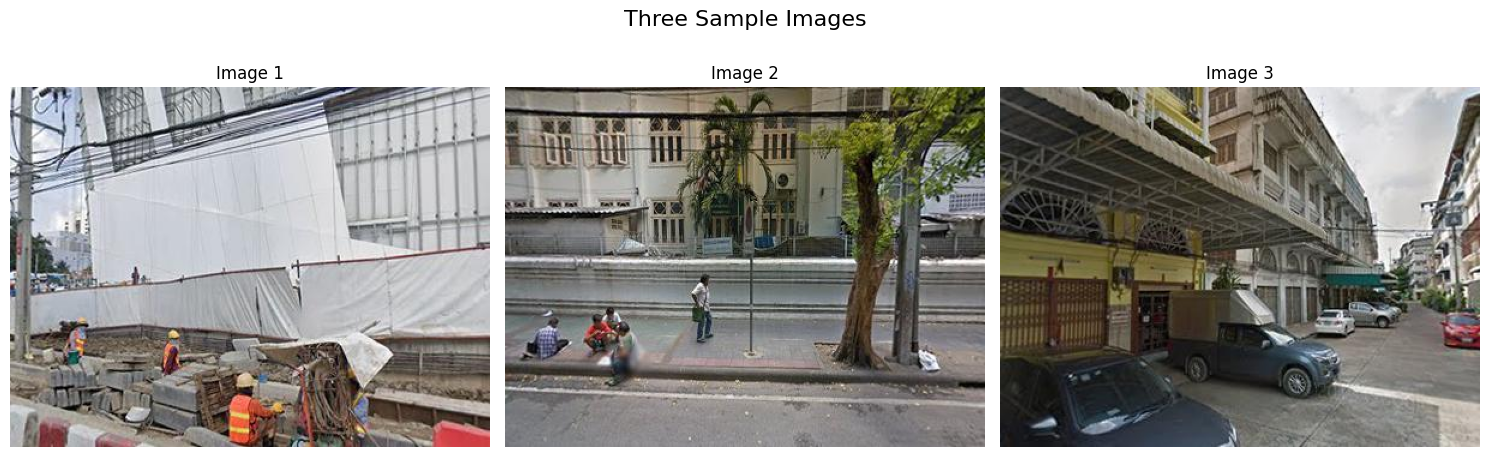

In [ ]:
# Creating subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Displaing the images
axes[0].imshow(final_dataset["image_rgb"][0])
axes[0].set_title("Image 1")
axes[0].axis("off")

axes[1].imshow(final_dataset["image_rgb"][1])
axes[1].set_title("Image 2")
axes[1].axis("off")

axes[2].imshow(final_dataset["image_rgb"][2])
axes[2].set_title("Image 3")
axes[2].axis("off")

# Adding a title
plt.suptitle("Three Sample Images", fontsize=16)

# Showing the figure
plt.tight_layout()
plt.show()

In order to reduce memory usage, i decided to crop the images and keep only the middle-bottom part, as they are street-level images and i think that is is more useful to focus on the road, vehicles and other relevant objects which are there. Cropping in this way removes elements such as the sky, buildings and others from the top liers of the images. I also keep the same dimensions in all images for consistency and uniformity.

In [ ]:
# Getting the unique combinations of height X width
final_dataset["image_rgb"].apply(lambda image: image.shape).unique()

array([(300, 400, 3), (480, 640, 3)], dtype=object)

Define a function to crop and resize the image and apply it on the final dataset

In [ ]:
def modify_image(image, crop_ratio=0.5, final_dimensions=(300, 150)):
    """
    This function used to crop and resize the image.

    :param image: The image to modify
    :param crop_ratio: The ration to use for cropping the image
    :param final_dimensions: The final dimensions of the image
    :return: The modified image
    """

    # Get image dimensions
    height, width = image.shape[:2]

    # Cropping
    crop_height = int(height * crop_ratio)
    cropped_image = image[height - crop_height :, :]

    # Resizing
    resized_image = cv2.resize(cropped_image, final_dimensions)

    return resized_image


# Cropping and resizing
final_dataset["image"] = final_dataset["image_rgb"].apply(
    lambda image: modify_image(image)
)

# Removing columns
final_dataset.drop(columns=["image_filename", "image_rgb"], inplace=True)

final_dataset.sample(5)

Show again the first three images as before to see the changes

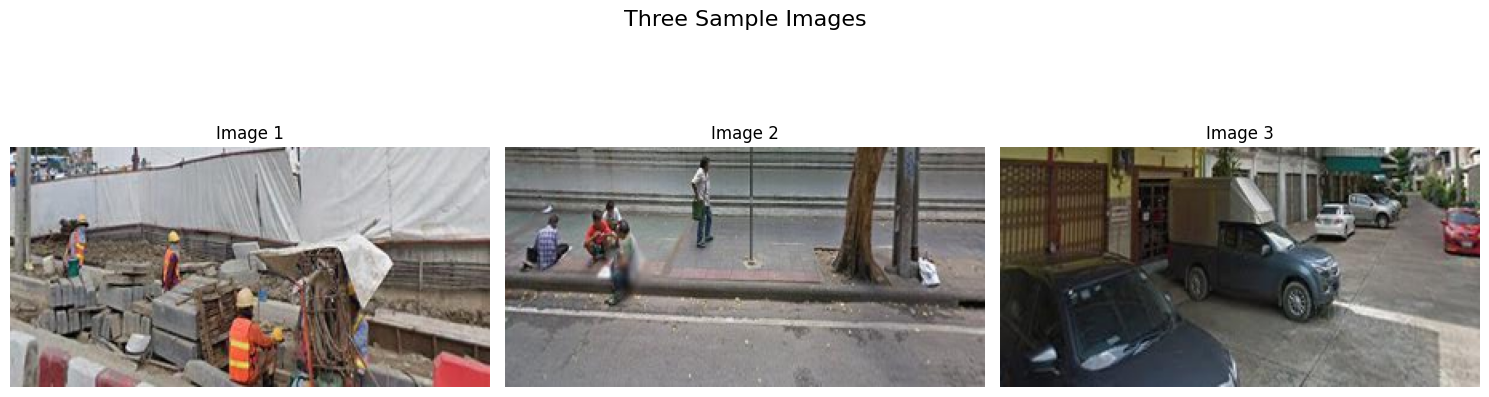

In [3]:
# Creating subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Displaing the images
axes[0].imshow(final_dataset["image"][0])
axes[0].set_title("Image 1")
axes[0].axis("off")

axes[1].imshow(final_dataset["image"][1])
axes[1].set_title("Image 2")
axes[1].axis("off")

axes[2].imshow(final_dataset["image"][2])
axes[2].set_title("Image 3")
axes[2].axis("off")

# Adding a title
plt.suptitle("Three Sample Images", fontsize=16)

# Showing the figure
plt.tight_layout()
plt.show()

Save the final dataset for reuse later in the next tasks

In [ ]:
# Connecting to drive
drive.mount("/content/drive")

# Save the DataFrame as a pickle file
final_dataset.to_pickle("/content/drive/My Drive/Datasets/final_dataset.pkl")

Mounted at /content/drive


##### **Task 2 - Exploratory Data Analysis**

Load the dataset from the previous task

In [2]:
# Connecting to drive
drive.mount("/content/drive")

# Loading the dataset
dataset = pd.read_pickle("/content/drive/My Drive/Datasets/final_dataset.pkl")

dataset.head(2)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


place_id  year  city_id        lat         lon  \
0      1074  2018  Bangkok  13.727106  100.509062   
1      3487  2014  Bangkok  13.755864  100.490876   

                                               image  
0  [[[17, 27, 33], [28, 32, 37], [17, 16, 17], [5...  
1  [[[76, 76, 74], [76, 77, 73], [75, 76, 71], [7...

In the results below we can see that there are 9.266 unique places in the dataset and their distribution in the cities. It is also visible that some places appear more than once within their city, as the number of total records per city is greater than its unique places.

In [3]:
# Getting all the unique places in the dataset
print("Total unique places:", len(dataset[["city_id", "place_id"]].drop_duplicates()))

# Getting unique places and total records per city
dataset.groupby(["city_id"]).agg(
    total_places=("place_id", "nunique"), total_entries=("place_id", "count")
)

Total unique places: 9266


total_places  total_entries
city_id                                  
Bangkok                397            421
Barcelona              263            300
Boston                 576            616
Brussels               255            268
BuenosAires            144            160
Chicago                593            644
Lisbon                 487            511
London                1000           1105
LosAngeles             154            168
Madrid                 254            275
Medellin               107            114
Melbourne              506            539
MexicoCity             203            242
Miami                  769            824
Minneapolis            398            422
OSL                    180            184
Osaka                  398            427
PRG                    318            332
PRS                    708            755
Phoenix                628            685
Rome                   418            455
TRT                    309            335
WashingtonDC           201            218

Speicifically, there are 693 places that appear more than once across the dataset.

In [4]:
# Getting some info about the places
places_info = dataset.groupby(["city_id", "place_id"], as_index=False).agg(
    frequency=("city_id", "count"),
    mean_lat=("lat", "mean"),
    std_lat=("lat", "std"),
    mean_lon=("lon", "mean"),
    std_lon=("lon", "std"),
)

# Rounding
places_info = places_info.round(6)

# Getting the places displayed more than once
print(
    "Total number of repeated places: ", len(places_info[places_info["frequency"] > 1])
)

Total number of repeated places:  693


The maximum number of images per place is 4 and there is only one place of this kind and also the corresponding minimum number is 2 and there are 653 related places

In [22]:
# Getting the maximum images per place
max_images = places_info[places_info["frequency"] > 1]["frequency"].max()

print("The maximum number of images per place: ", max_images)
print(
    "Quantity of this kind (max) of places:",
    len(places_info[places_info["frequency"] == max_images]),
)

# Getting the minimum images per place
min_images = places_info[places_info["frequency"] > 1]["frequency"].min()

print("\nThe minimum number of images per place: ", min_images)
print(
    "Quantity of this kind (min) of places:",
    len(places_info[places_info["frequency"] == min_images]),
)

The maximum number of images per place:  4
Quantity of this kind (max) of places: 1

The minimum number of images per place:  2
Quantity of this kind (min) of places: 653


After exploring the results of the dataframe below, we can observe that the places that appear more than once do not have significantly different coordinates, as their standard deviations are very small and close to zero. This means that the images of these places was taken from a different street position changing their coordinates slightly. Based on this, we can assume that taking the average of the coordinates describes their location very well.

In [5]:
# Getting the places displayed more than once
places_info[places_info["frequency"] > 1]

city_id  place_id  frequency   mean_lat   std_lat    mean_lon  \
4          Bangkok        58          2  13.717023  0.000004  100.540830   
18         Bangkok       216          2  13.717569  0.000003  100.525745   
20         Bangkok       221          2  13.717348  0.000021  100.530706   
35         Bangkok       393          2  13.719341  0.000000  100.528628   
40         Bangkok       420          2  13.719328  0.000001  100.552897   
49         Bangkok       474          2  13.720366  0.000009  100.524725   
56         Bangkok       531          2  13.721216  0.000000  100.494741   
60         Bangkok       594          2  13.720949  0.000001  100.557593   
68         Bangkok       730          2  13.723554  0.000006  100.514658   
81         Bangkok       839          2  13.724774  0.000015  100.540569   
83         Bangkok       883          2  13.725371  0.000001  100.496670   
110        Bangkok      1207          2  13.728269  0.000013  100.559939   
125        Bangkok      1412          2  13.731240  0.000012  100.507761   
179        Bangkok      2159          2  13.739059  0.000022  100.557645   
194        Bangkok      2339          2  13.741234  0.000025  100.564487   
200        Bangkok      2395          2  13.742241  0.000004  100.525826   
204        Bangkok      2420          2  13.742162  0.000003  100.557709   
209        Bangkok      2466          2  13.743295  0.000003  100.511702   
270        Bangkok      3310          2  13.753317  0.000018  100.486220   
314        Bangkok      3984          2  13.760142  0.000005  100.555750   
332        Bangkok      4199          2  13.762784  0.000008  100.508776   
363        Bangkok      4407          2  13.765380  0.000004  100.542564   
365        Bangkok      4416          2  13.765288  0.000022  100.545605   
368        Bangkok      4470          2  13.764498  0.000006  100.519837   
400      Barcelona        17          2  41.356033  0.000010    2.138031   
409      Barcelona       128          2  41.359031  0.000012    2.128282   
418      Barcelona       231          2  41.362281  0.000002    2.124911   
424      Barcelona       257          2  41.362483  0.000006    2.169386   
429      Barcelona       298          2  41.363975  0.000012    2.139424   
431      Barcelona       312          2  41.364068  0.000003    2.161495   
433      Barcelona       346          2  41.365526  0.000025    2.120267   
437      Barcelona       358          2  41.365752  0.000010    2.144731   
438      Barcelona       370          2  41.365445  0.000014    2.170252   
446      Barcelona       465          2  41.368914  0.000014    2.138305   
451      Barcelona       509          2  41.370331  0.000015    2.120139   
471      Barcelona       632          2  41.373490  0.000005    2.133069   
476      Barcelona       666          2  41.375756  0.000003    2.190101   
492      Barcelona       788          2  41.378842  0.000014    2.114207   
494      Barcelona       796          2  41.378286  0.000005    2.136215   
506      Barcelona       945          2  41.381543  0.000021    2.190463   
519      Barcelona      1033          2  41.384630  0.000013    2.145872   
523      Barcelona      1060          2  41.385272  0.000003    2.193095   
535      Barcelona      1144          2  41.387945  0.000004    2.155440   
545      Barcelona      1227          2  41.389547  0.000008    2.193777   
546      Barcelona      1231          2  41.391136  0.000010    2.113801   
549      Barcelona      1235          2  41.390597  0.000001    2.115191   
555      Barcelona      1261          3  41.390964  0.000015    2.153670   
558      Barcelona      1267          2  41.391346  0.000001    2.161535   
561      Barcelona      1283          2  41.391179  0.000005    2.198775   
576      Barcelona      1373          2  41.394532  0.000002    2.152096   
590      Barcelona      1431          2  41.395953  0.000002    2.157045   
606      Barcelona      1496          3  41.397569  0.00001

Let's find the pairs of places with the shortest and longest distance in each city

Define a function to find the pairs and distances

In [7]:
def calculate_distances(city):
    """
    This function used to find the the pairs of places with the shortest and
    longest distance for a city

    :param city: The city to be used
    :return: The pairs of places with the shortest and longest distance
    """

    # Getting the places
    places = city[["place_id", "mean_lat", "mean_lon"]].values

    # Getting the number of places
    total_places = len(places)

    # Setting up the variables to store the distances and pairs
    smallest_distance = float("inf")
    largest_distance = float("-inf")
    smallest_pair = None
    largest_pair = None

    # Iterating over all places
    for index_1 in range(total_places):

        # Iterating over places which are after the one selected from
        # the previous loop
        for index_2 in range(index_1 + 1, total_places):

            # Extracting the info about the places
            place_1, lat_1, lon_1 = places[index_1]
            place_2, lat_2, lon_2 = places[index_2]

            # Getting the distance in kilometers
            distance = geodesic((lat_1, lon_1), (lat_2, lon_2)).kilometers

            # Checking if the distance is less than the final
            if distance < smallest_distance:

                # Updating
                smallest_distance = distance
                smallest_pair = (place_1, (lat_1, lon_1), place_2, (lat_2, lon_2))

            # Checking if the distance is greater than the final
            if distance > largest_distance:

                # Updating
                largest_distance = distance
                largest_pair = (place_1, (lat_1, lon_1), place_2, (lat_2, lon_2))

    return {
        "city": city["city_id"].iloc[0],
        "smallest_pair": smallest_pair[:2] + smallest_pair[2:],
        "smallest_distance_km": smallest_distance,
        "largest_pair": largest_pair[:2] + largest_pair[2:],
        "largest_distance_km": largest_distance,
    }


# Calculating the pairs with the shortest and longest distances for each city
pairs_distances_by_city = pd.DataFrame(
    [calculate_distances(city) for _, city in places_info.groupby("city_id")]
)

# Showing some results
pairs_distances_by_city.head(2)

city                                      smallest_pair  \
0    Bangkok  (1027.0, (13.725962, 100.552669), 1028.0, (13....   
1  Barcelona  (665.0, (41.375731, 2.190094), 666.0, (41.3757...   

   smallest_distance_km                                       largest_pair  \
0              0.022755  (88.0, (13.716166, 100.484582), 4788.0, (13.76...   
1              0.002838  (58.0, (41.357836, 2.111924), 1790.0, (41.4055...   

   largest_distance_km  
0            10.927196  
1             8.867995

Get the distances in meters

In [8]:
# Getting the distances in meters
pairs_distances_by_city.insert(
    loc=3,
    column="smallest_distance_meter",
    value=pairs_distances_by_city["smallest_distance_km"] * 1000,
)
pairs_distances_by_city["largest_distance_meter"] = (
    pairs_distances_by_city["largest_distance_km"] * 1000
)

# Showing some results
pairs_distances_by_city.head(2)

city                                      smallest_pair  \
0    Bangkok  (1027.0, (13.725962, 100.552669), 1028.0, (13....   
1  Barcelona  (665.0, (41.375731, 2.190094), 666.0, (41.3757...   

   smallest_distance_km  smallest_distance_meter  \
0              0.022755                 22.75496   
1              0.002838                  2.83761   

                                        largest_pair  largest_distance_km  \
0  (88.0, (13.716166, 100.484582), 4788.0, (13.76...            10.927196   
1  (58.0, (41.357836, 2.111924), 1790.0, (41.4055...             8.867995   

   largest_distance_meter  
0            10927.196326  
1             8867.994886

Define a function for depicting pairs of places and their distances on the map. The shortest pairs are coloured blue, while the longest pairs are coloured red.

In [9]:
def add_pair_to_map(map, city, pair, distance_km, distance_meter, type):
    """
    This function used to add a pair of places and their distance on the map.

    :param map: The map
    :param city: The city
    :param pair: The pair of places
    :param distance_km: The distance between the places in kilometers
    :param distance_meter: The distance between the places in meters
    :param type: The type of the pair (shortest or longest)
    """

    # Getting the info about the places
    place_1, coords_1, place_2, coords_2 = pair

    # Adding the first place
    folium.CircleMarker(
        location=coords_1,
        color="blue" if type == "Shortest" else "red",
        radius=5,
        fill=True,
        fill_color="blue" if type == "Shortest" else "red",
        fill_opacity=0.7,
    ).add_child(
        folium.Popup(f"<b>City:</b> {city}<br><b>Place:</b> {place_1}", max_width=300)
    ).add_to(
        map
    )

    # Adding the second place
    folium.CircleMarker(
        location=coords_2,
        color="blue" if type == "Shortest" else "red",
        radius=5,
        fill=True,
        fill_color="blue" if type == "Shortest" else "red",
        fill_opacity=0.7,
    ).add_child(
        folium.Popup(f"<b>City:</b> {city}<br><b>Place:</b> {place_2}", max_width=300)
    ).add_to(
        map
    )

    # Adding the line between the places
    folium.PolyLine(
        locations=[coords_1, coords_2],
        color="blue" if type == "Shortest" else "red",
        weight=4,
        tooltip=f"{type} Distance (kilometers): {distance_km:.4f} <br> {type} Distance (meters): {distance_meter:.2f}",
    ).add_to(map)


# Create a folium map
map = folium.Map(location=[0, 0], zoom_start=2)

# Iterating over all pairs
for _, row in pairs_distances_by_city.iterrows():

    # Adding the pairs to the map
    add_pair_to_map(
        map,
        row["city"],
        row["smallest_pair"],
        row["smallest_distance_km"],
        row["smallest_distance_meter"],
        "Shortest",
    )
    add_pair_to_map(
        map,
        row["city"],
        row["largest_pair"],
        row["largest_distance_km"],
        row["largest_distance_meter"],
        "Longest",
    )

# Showing the map
map

Below we can see some statistical measurements for the coordinates appeared in each city

In [10]:
# Getting some statistical metrics
coordinates_metrics = dataset.groupby("city_id", as_index=False).agg(
    min_lat=("lat", "min"),
    max_lat=("lat", "max"),
    mean_lat=("lat", "mean"),
    std_lat=("lat", "std"),
    min_lon=("lon", "min"),
    max_lon=("lon", "max"),
    mean_lon=("lon", "mean"),
    std_lon=("lon", "std"),
)

# Melting
melted_coordinates_metrics = coordinates_metrics.melt(
    id_vars=["city_id"], var_name="metric", value_name="value"
)

# Pivoting
pivoted_coordinates_metrics = melted_coordinates_metrics.pivot(
    index="metric", columns="city_id", values="value"
).reindex(coordinates_metrics.columns[1:])

# Removing indices names
pivoted_coordinates_metrics.columns.name = None
pivoted_coordinates_metrics.index.name = None

pivoted_coordinates_metrics

Bangkok  Barcelona     Boston   Brussels  BuenosAires    Chicago  \
min_lat    13.714734  41.356026  42.321952  50.828899   -34.627283  41.837129   
max_lat    13.771996  41.405793  42.398225  50.866256   -34.577657  41.925842   
mean_lat   13.741907  41.383981  42.358824  50.847654   -34.605492  41.884235   
std_lat     0.016694   0.014352   0.020881   0.011413     0.014618   0.023309   
min_lon   100.483664   2.110259 -71.136033   4.306949   -58.424225 -87.689033   
max_lon   100.569823   2.198797 -71.019018   4.384570   -58.363538 -87.610530   
mean_lon  100.527286   2.152546 -71.088875   4.345788   -58.395148 -87.654032   
std_lon     0.024642   0.024507   0.028979   0.022340     0.016423   0.019848   

             Lisbon     London  LosAngeles     Madrid   Medellin   Melbourne  \
min_lat   38.703837  51.486064   34.031815  40.393969   6.230672  -37.854924   
max_lat   38.777674  51.531411   34.056210  40.430627   6.254139  -37.793614   
mean_lat  38.740507  51.509115   34.043827  40.412726   6.242283  -37.823995   
std_lat    0.020254   0.013969    0.006742   0.010930   0.006811    0.017365   
min_lon   -9.241602  -0.180797 -118.269427  -3.713543 -75.608051  144.927782   
max_lon   -9.114290  -0.079977 -118.233770  -3.658051 -75.556437  145.024946   
mean_lon  -9.175204  -0.128765 -118.250039  -3.685815 -75.580735  144.974296   
std_lon    0.033769   0.028056    0.010407   0.017274   0.012493    0.025353   

          MexicoCity      Miami  Minneapolis        OSL       Osaka  \
min_lat    19.398770  25.730690    44.938257  59.901133   34.644302   
max_lat    19.437999  25.797087    44.995496  59.957111   34.703472   
mean_lat   19.417574  25.765730    44.966583  59.929702   34.673602   
std_lat     0.011944   0.017592     0.017155   0.012839    0.017712   
min_lon   -99.186088 -80.303959   -93.299641  10.643481  135.470939   
max_lon   -99.136492 -80.179935   -93.209114  10.793702  135.529219   
mean_lon  -99.162335 -80.238980   -93.253629  10.726253  135.499009   
std_lon     0.014599   0.032229     0.024561   0.041270    0.016324   

                PRG        PRS     Phoenix       Rome        TRT  WashingtonDC  
min_lat   50.037654  48.797009   33.421895  41.871696  43.622008     38.887537  
max_lat   50.121163  48.905750   33.487442  41.911740  43.733991     38.921052  
mean_lat  50.077634  48.854828   33.456584  41.890948  43.679922     38.905248  
std_lat    0.022639   0.029754    0.017208   0.011488   0.028327      0.009697  
min_lon   14.329475   2.209288 -112.122446  12.456981 -79.663258    -77.056311  
max_lon   14.518847   2.463440 -112.026636  12.530981 -79.278830    -76.998240  
mean_lon  14.429047   2.336578 -112.072739  12.494368 -79.458387    -77.025369  
std_lon    0.052496   0.068419    0.027540   0.020351   0.098098      0.017428

All images were taken from the years 2007 to 2020, with most of the images appearing in 2014 and the fewest in 2010

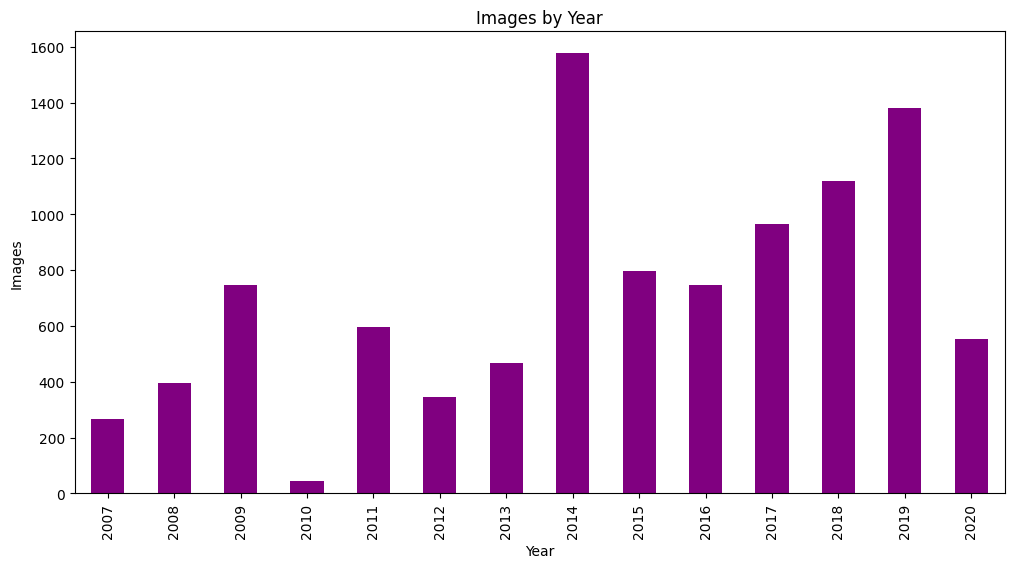

In [11]:
# Getting images per year
year_counts = dataset["year"].value_counts().sort_index()

# Plotting
year_counts.plot.bar(figsize=(12, 6), color="purple")
plt.xlabel("Year")
plt.ylabel("Images")
plt.title("Images by Year")
plt.show()

Find the images per year and city

In [12]:
# Finding the images per year and city
images_by_year_city = (
    dataset.groupby(["year", "city_id"])
    .agg(total_images=("image", "count"))
    .sort_values(by="year", ascending=True)
    .reset_index()
)

# Pivoting
images_by_year_city = images_by_year_city.pivot(
    index="year", columns="city_id", values="total_images"
).fillna(0)

# Removing indices names
images_by_year_city.columns.name = None
images_by_year_city.index.name = None

# Getting a sample
images_by_year_city.sample(5)

Bangkok  Barcelona  Boston  Brussels  BuenosAires  Chicago  Lisbon  \
2011     47.0        4.0    73.0       2.0          0.0     59.0     0.0   
2015      2.0       32.0    13.0       0.0         18.0     81.0    18.0   
2012      1.0       14.0    17.0       0.0          0.0     20.0     0.0   
2008      0.0       37.0     1.0       0.0          0.0      4.0     0.0   
2019     97.0       39.0    53.0      56.0         25.0     63.0    80.0   

      London  LosAngeles  Madrid  Medellin  Melbourne  MexicoCity  Miami  \
2011     0.0         8.0    10.0       0.0        0.0        27.0   89.0   
2015   123.0         9.0    31.0      12.0       16.0        23.0  123.0   
2012    91.0         6.0    15.0       0.0        0.0         5.0    0.0   
2008    81.0         4.0    32.0       0.0        7.0        22.0   30.0   
2019   108.0        19.0    33.0      23.0       96.0        26.0  114.0   

      Minneapolis   OSL  Osaka   PRG   PRS  Phoenix  Rome   TRT  WashingtonDC  
2011         56.0   0.0    0.0  59.0  15.0     67.0  18.0  34.0          29.0  
2015          6.0   0.0   59.0   0.0  79.0     60.0  51.0  39.0           2.0  
2012          5.0  16.0    1.0  41.0  72.0      0.0  20.0  16.0           4.0  
2008          7.0   0.0    0.0   0.0  72.0     59.0  36.0   0.0           4.0  
2019         73.0  44.0   48.0  78.0  92.0     84.0  42.0  61.0          25.0

Below we can see the frequency evolution of the images for each city

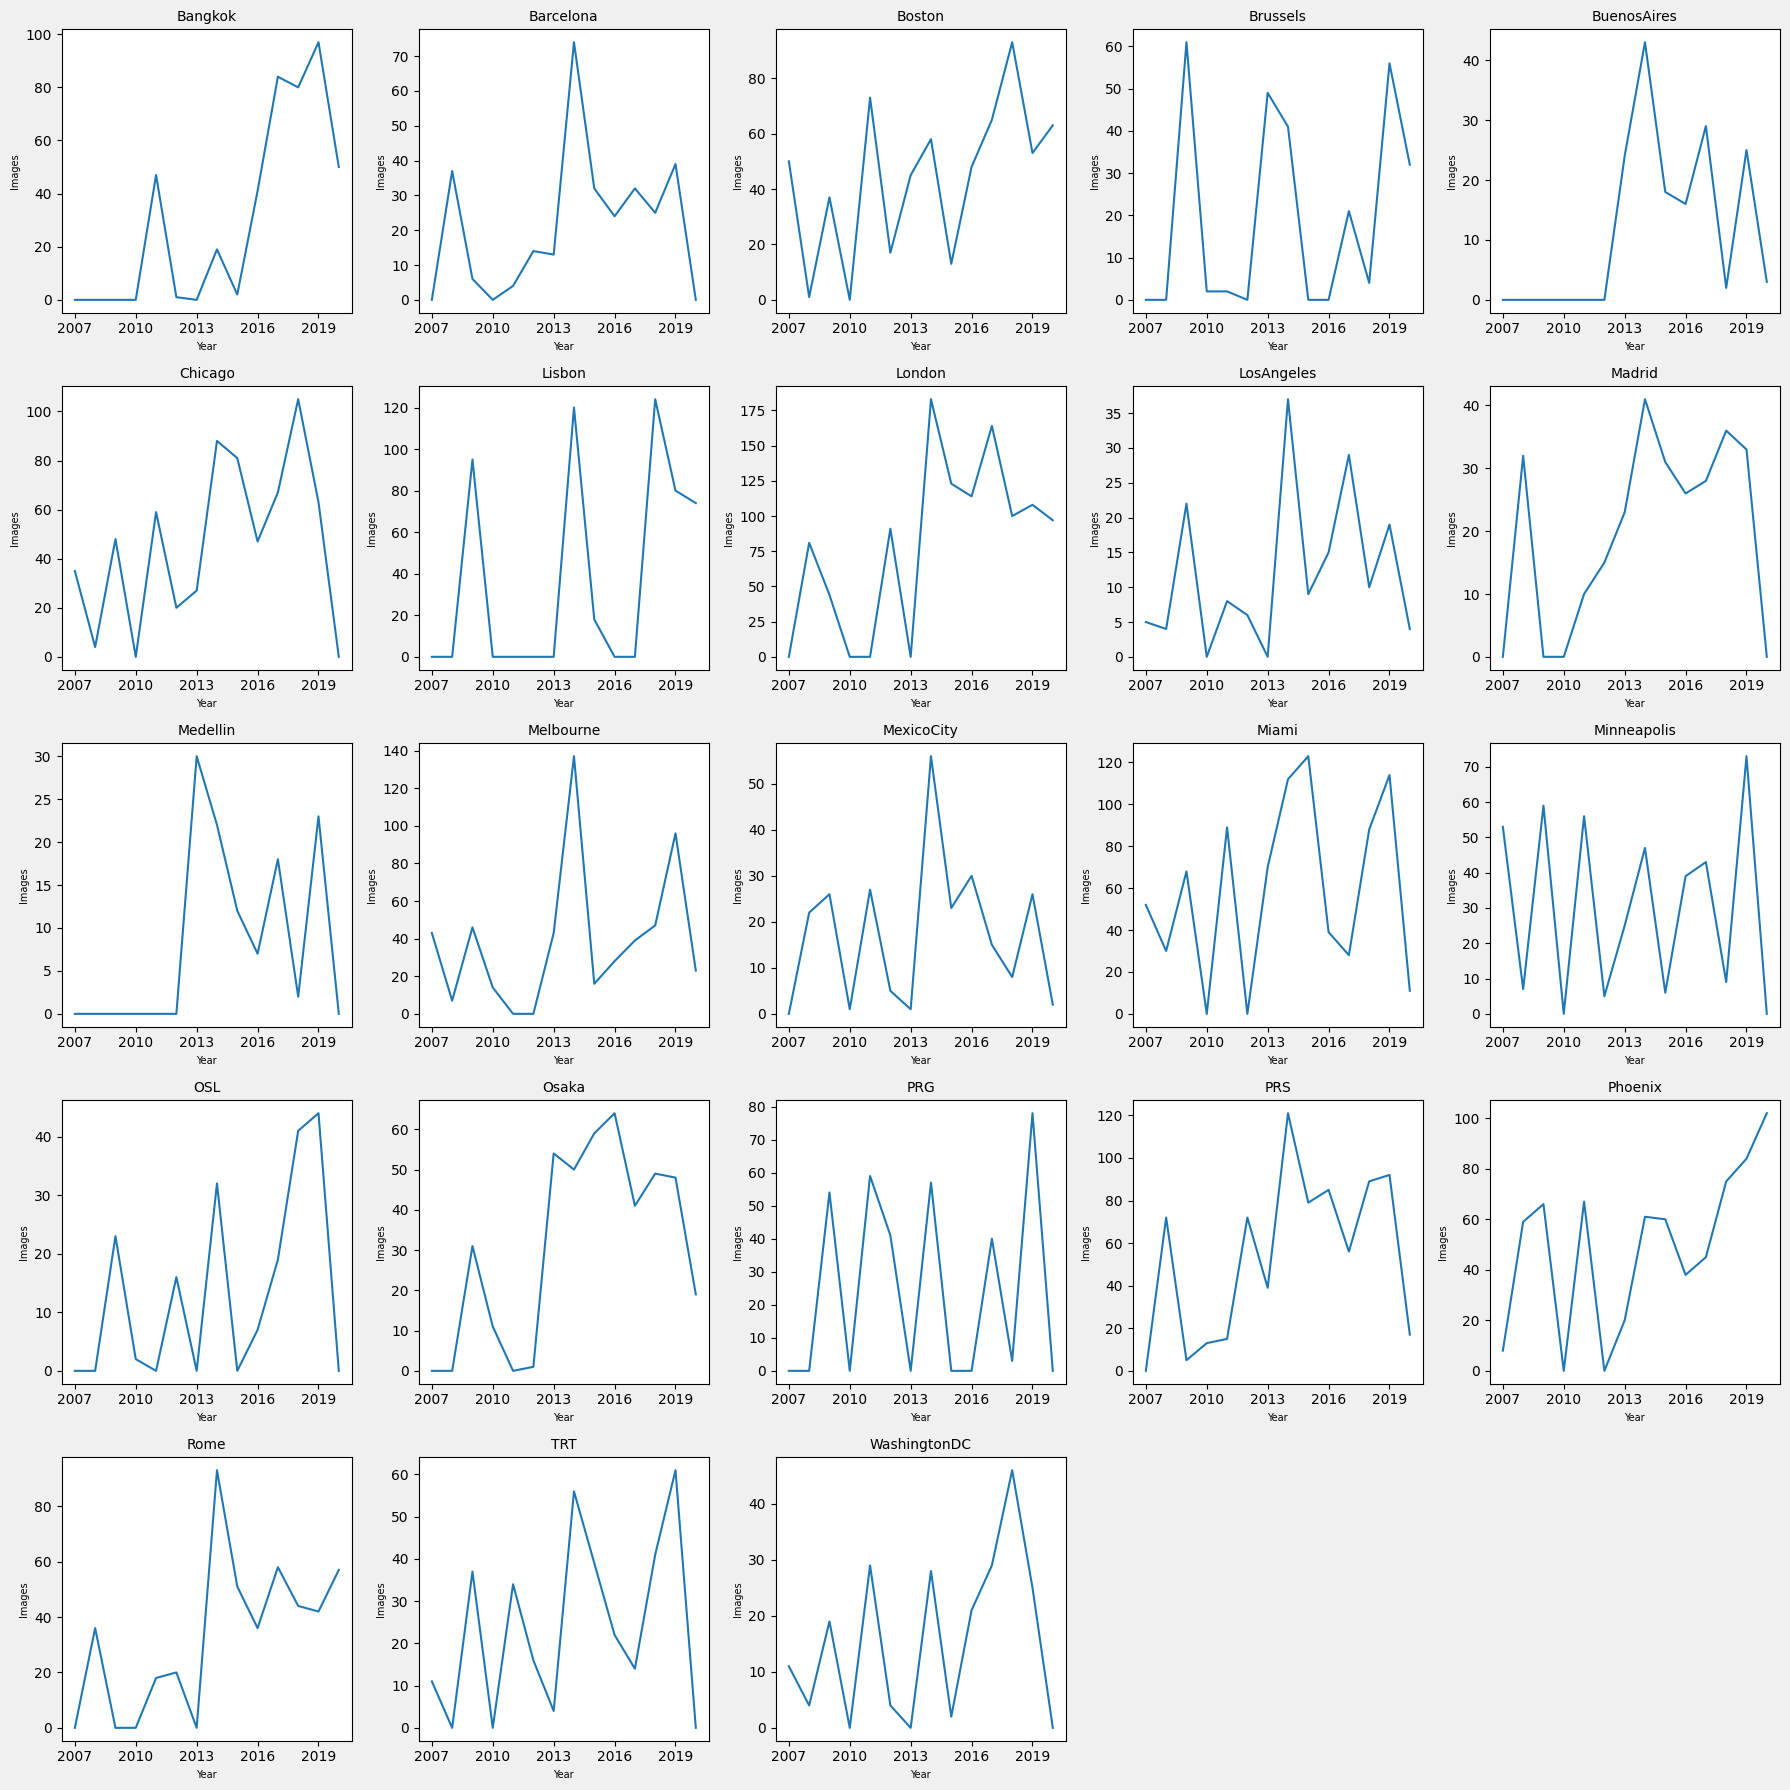

In [13]:
# Creating the figure and flattening the axes
fig, axes = plt.subplots(nrows=5, ncols=5, figsize=(18, 18))
axes = axes.flatten()

# Setting up the background color
fig.set_facecolor("#f0f0f0")

# Iterating over each city and creating the subplot
for index, city in enumerate(images_by_year_city.columns):

    # Getting the current subplot
    ax = axes[index]

    # Plotting
    ax.plot(images_by_year_city.index, images_by_year_city[city], label=city)

    # Setting up some parameters of the plot
    ax.set_title(city, fontsize=10)
    ax.set_xticks(range(2007, 2021, 3))
    ax.set_xlabel("Year", fontsize=7)
    ax.set_ylabel("Images", fontsize=7)

# Removing axes for any unused subplot
axes[23].axis("off")
axes[24].axis("off")

# Showing
plt.tight_layout()
plt.show()

Most of the cities show the highest number of images after 2014 and all have zero images for one or more years

Define a function for calculating the brightness of an image based on the Luminance formula and using the RGB format

$$
Brightness  = 0.2126 \times R + 0.7152 \times G + 0.0722 \times B
$$

In [23]:
def calculate_brightness(image):
    """
    This funvtion used to calculate the brightness of an image based on the
    Luminance formula

    :param image: The image to calculate the brightness of
    :return: The brightness of the image

    """

    # Calculating brightness
    brightness = (
        0.2126 * image[:, :, 0] + 0.7152 * image[:, :, 1] + 0.0722 * image[:, :, 2]
    )

    return np.mean(brightness)


# Calculating brightness for each image
dataset["brightness"] = dataset["image"].apply(calculate_brightness)

dataset.head(2)

place_id  year  city_id        lat         lon  \
0      1074  2018  Bangkok  13.727106  100.509062   
1      3487  2014  Bangkok  13.755864  100.490876   

                                               image  brightness  
0  [[[17, 27, 33], [28, 32, 37], [17, 16, 17], [5...  135.385337  
1  [[[76, 76, 74], [76, 77, 73], [75, 76, 71], [7...  119.460784

Get the average image brigthness level per city

In [51]:
# Getting the mean per city
city_brightness = (
    dataset.groupby("city_id")
    .agg(Brightness=("brightness", "mean"))
    .sort_values(by="Brightness", ascending=True)
)

city_brightness

Brightness
city_id                 
BuenosAires    99.821847
London        100.131475
MexicoCity    101.009882
Melbourne     101.057540
PRS           102.495321
Madrid        103.357180
PRG           104.371015
Brussels      104.578420
Barcelona     105.771083
Boston        105.990865
Rome          106.056113
OSL           106.686776
Osaka         107.243643
Chicago       107.377719
Minneapolis   107.507744
Medellin      107.962931
Bangkok       107.974948
WashingtonDC  110.550980
TRT           111.790558
Lisbon        112.568230
Miami         114.190787
LosAngeles    114.266831
Phoenix       125.452996

Visualize the different levels of image brightness across the cities

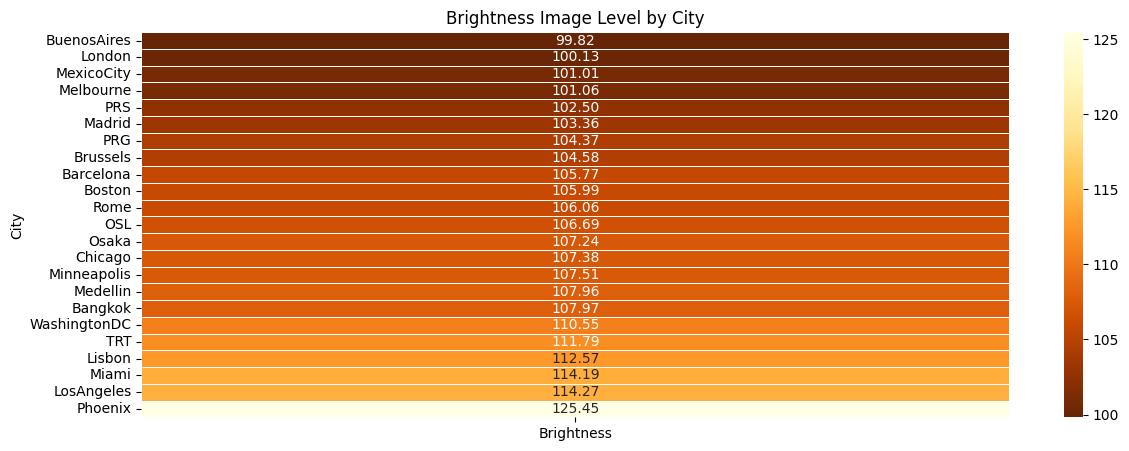

In [53]:
# Creating the heatmap
plt.figure(figsize=(14, 5))
sns.heatmap(
    city_brightness,
    annot=True,
    fmt=".2f",
    cmap="YlOrBr_r",
    cbar=True,
    linewidths=0.5,
)
plt.title("Brightness Image Level by City")
plt.ylabel("City")
plt.show()

We observe that the brightness level increases gradually with the most recent cities showing a similar brightness scale, which is shown in the middle part of the diagram. The Phoenix contains images with the highest average brightness level as opposed to the BuenosAires which shows the lowest. In general, if we consider the 0-255 scale for the brightness level, then the images of all the cities are somewhere in the middle and a little lower

**Below we can see what we have analysed and found. For more information and explanations see the particular analyses above in this task**

1. Total unique places
2. Total unique places and records for each city
3. Total number of places appeared more than once and statistic metrics for their coordinates
4. Statistical measurements for the coordinates of each city
5. Max and min number of images per place
6. The shortest and longest pair of places for each city
7. The distribution of the images over the years and cities
8. The different levels of image brightness in the cities

##### **Task 3 - Unsupervised Learning**

Define two functions, where the first one is used to prepare the images for feature extraction and the second one is used to extract the features using the "VGG16" model and which will be used in the clustering process.

In [4]:
def prepare_images(images):
    """
    This function is used to prepare and process the images for
    feature extraction.

    :param images: The images to prepare
    :return: The processed images
    """

    # Resizing the images to 224x224 which is a requirement of the model
    processed_images = np.array(
        [resize(img, (224, 224), anti_aliasing=True) for img in images]
    )

    # Processing the images
    processed_images = preprocess_input(processed_images.astype("float32"))

    return processed_images


def extract_features(model, images, batch_size=32):
    """
    This function used to extract features from images in batches.

    :param model: The model to use for feature extraction.
    :param images: List of images to extract features from.
    :param batch_size: Number of images to process in each batch.
    :return: Extracted features.
    """

    # Getting the number of images
    num_images = len(images)

    # Setting a list to store all the features
    all_features = []

    # Iterating over the images using batches
    for start in range(0, num_images, batch_size):

        # Getting the end index of the current batch
        end = min(start + batch_size, num_images)

        # Getting the batch
        batch_images = images[start:end]

        # Processing the images in the current batch
        processed_images = prepare_images(batch_images)

        # Extracting features
        features = model.predict(processed_images)

        # Flattening
        features_flattened = [feature.flatten() for feature in features]

        # Updating
        all_features.extend(features_flattened)

    return np.array(all_features)

Load the dataset from the task 1

In [ ]:
# Connecting to drive
drive.mount("/content/drive")

# Loading the dataset
dataset = pd.read_pickle("/content/drive/My Drive/Datasets/final_dataset.pkl")

Extract image features

In [5]:
# Downloading the 'VGG16' model and placing it on the GPU
with tf.device("/GPU:0"):
    model = VGG16(include_top=False, weights="imagenet")

# Extracting features for the images
features = extract_features(model, dataset["image"].tolist())

1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━

Normalize the features and reduce their dimensionality

In [6]:
# Normalizing the features
scaler = StandardScaler()
features_normalized = scaler.fit_transform(features)

# Appling PCA to reduce the dimensionality of the features
pca = PCA(n_components=124, random_state=42)
features_reduced = pca.fit_transform(features_normalized)

# Storing the final features of the images
dataset["features"] = list(map(np.array, features_reduced))

dataset.head(2)

place_id  year  city_id        lat         lon  \
0      1074  2018  Bangkok  13.727106  100.509062   
1      3487  2014  Bangkok  13.755864  100.490876   

                                               image  \
0  [[[17, 27, 33], [28, 32, 37], [17, 16, 17], [5...   
1  [[[76, 76, 74], [76, 77, 73], [75, 76, 71], [7...   

                                            features  
0  [12.627361, -4.499857, -0.7665824, 8.874344, -...  
1  [-3.4990487, 0.09695152, -0.25022784, -1.63275...

Test different values of K parameter to see which one gives better results for the clustering using the Silhouette method

For K = 2, the average silhouette score is : 0.2224305123090744
For K = 3, the average silhouette score is : 0.21625521779060364
For K = 4, the average silhouette score is : 0.21547196805477142
For K = 5, the average silhouette score is : 0.08037454634904861
For K = 6, the average silhouette score is : 0.08171505481004715
For K = 7, the average silhouette score is : 0.09404374659061432
For K = 8, the average silhouette score is : 0.08816665410995483
For K = 9, the average silhouette score is : 0.07977721095085144
For K = 10, the average silhouette score is : 0.0799252837896347
For K = 11, the average silhouette score is : 0.06564707309007645
For K = 12, the average silhouette score is : 0.06481470912694931
For K = 13, the average silhouette score is : 0.04741190746426582
For K = 14, the average silhouette score is : 0.056226130574941635
For K = 15, the average silhouette score is : 0.036365851759910583

The best K value based on the Silhouette method is: 2


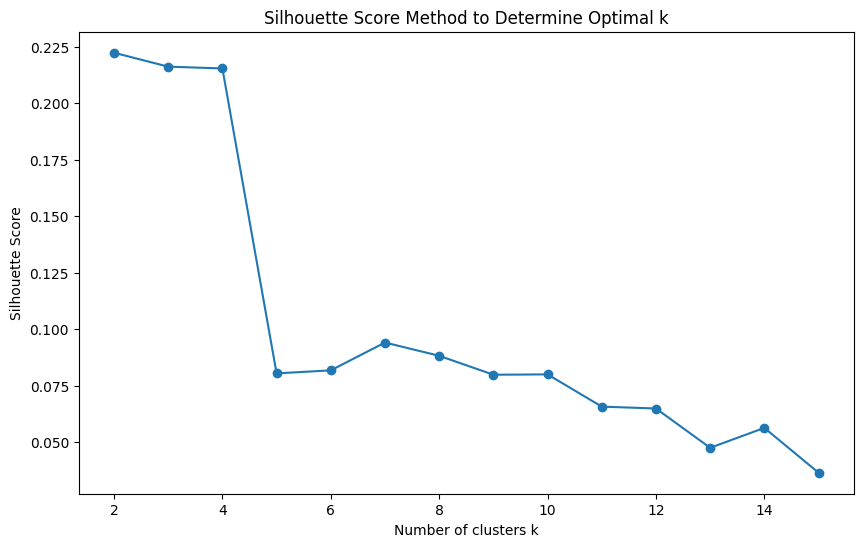

In [7]:
# Setting a list to store the average silhouette score for each k
silhouette_scores = []

# Setting the k values to test
k_values = range(2, 16)

# Iterating over the k values
for k in k_values:

    # Setting the KMeans model
    kmeans_test = KMeans(n_clusters=k, random_state=42)

    # Getting the clusters
    clusters = kmeans_test.fit_predict(features_reduced)

    # Getting the average silhouette score
    score = silhouette_score(features_reduced, clusters)

    # Updating
    silhouette_scores.append(score)

    print(f"For K = {k}, the average silhouette score is : {score}")

# Getting the best k values
best_k = k_values[silhouette_scores.index(max(silhouette_scores))]

print(f"\nThe best K value based on the Silhouette method is: {best_k}")

# Plotting the results
plt.figure(figsize=(10, 6))
plt.plot(k_values, silhouette_scores, marker="o")
plt.xlabel("Number of clusters k")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Score Method to Determine Optimal k")
plt.show()

Based on the above results we can observe that the best K value that can be used is 2, which gives the best silhouette score. However, I will choose the value 3 to get more clusters, while keeping the silhouette score high. I do not choose value 4 since as you can see below we do not get much more information than with K equal to 3, since the new cluster created has only 1 image and the distribution of the rest remains almost the same. So, we continue with the value 3.

In [8]:
# Fitting the model
kmeans_model = KMeans(n_clusters=3, random_state=42).fit(features_reduced)

# Getting the clusters
clusters = kmeans_model.labels_

print(f"For K = 3:")
print(f"Number of images in cluster 0: {np.sum(clusters == 0)}")
print(f"Number of images in cluster 1: {np.sum(clusters == 1)}")
print(f"Number of images in cluster 2: {np.sum(clusters == 2)}\n")

# Fitting the model
kmeans_model = KMeans(n_clusters=4, random_state=42).fit(features_reduced)

# Getting the clusters
clusters = kmeans_model.labels_

print(f"For K = 4:")
print(f"Number of images in cluster 0: {np.sum(clusters == 0)}")
print(f"Number of images in cluster 1: {np.sum(clusters == 1)}")
print(f"Number of images in cluster 2: {np.sum(clusters == 2)}")
print(f"Number of images in cluster 3: {np.sum(clusters == 3)}")

For K = 3:
Number of images in cluster 0: 3494
Number of images in cluster 1: 6501
Number of images in cluster 2: 5

For K = 4:
Number of images in cluster 0: 3508
Number of images in cluster 1: 6487
Number of images in cluster 2: 4
Number of images in cluster 3: 1


Train with K equal to 3

In [9]:
# Fitting the model
kmeans_model = KMeans(n_clusters=3, random_state=42).fit(features_reduced)

# Getting the clusters
clusters = kmeans_model.labels_

# Assigning cluster per image
dataset["cluster"] = clusters

# Getting the centroids of the clusters
clusters_centroids = kmeans_model.cluster_centers_

Below we can see the final labels of the clusters, and the centroid of each cluster that best describes the type and images included in each cluster.

In [10]:
print("Final cluster labels:", clusters)
print("Cluster Centers:", clusters_centroids)

Final cluster labels: [0 1 1 ... 1 1 0]
Cluster Centers: [[ 9.35162258e+00 -2.68799329e+00 -3.73501301e-01  3.74402374e-01
  -3.70316416e-01 -1.93663925e-01  8.66549164e-02 -4.35648441e-01
  -4.92414385e-01 -6.30332455e-02 -3.87746207e-02 -1.82675272e-01
   9.93065909e-02  4.03194912e-02  1.24382839e-01  2.23026499e-02
   7.96154514e-02 -4.20808978e-02  3.48804966e-02 -1.56588131e-03
   2.45023109e-02  6.17245387e-05 -1.04244046e-01  7.90966004e-02
  -5.16187139e-02  2.35398998e-03 -8.19237786e-04  5.88884810e-03
   6.50007511e-03  4.04043272e-02 -4.77848239e-02  8.40351284e-02
  -4.55153324e-02  6.70662289e-03 -1.76642947e-02 -2.57997569e-02
   9.93895903e-03 -1.45143718e-02  6.50762056e-04 -8.55219588e-02
  -4.44161817e-02 -1.15121230e-02 -1.06489239e-02 -2.45761704e-02
   1.08530875e-02  7.81175774e-03 -2.60695480e-02 -8.20507202e-03
  -3.39301974e-02  1.45566585e-02 -2.45577507e-02  5.57306223e-02
   2.07379013e-02 -2.46842913e-02 -1.93162411e-02 -2.73251403e-02
   1.45170477e-03  

Apply t-SNE for reducing the dimensionality one more time in order to visualize the clusters

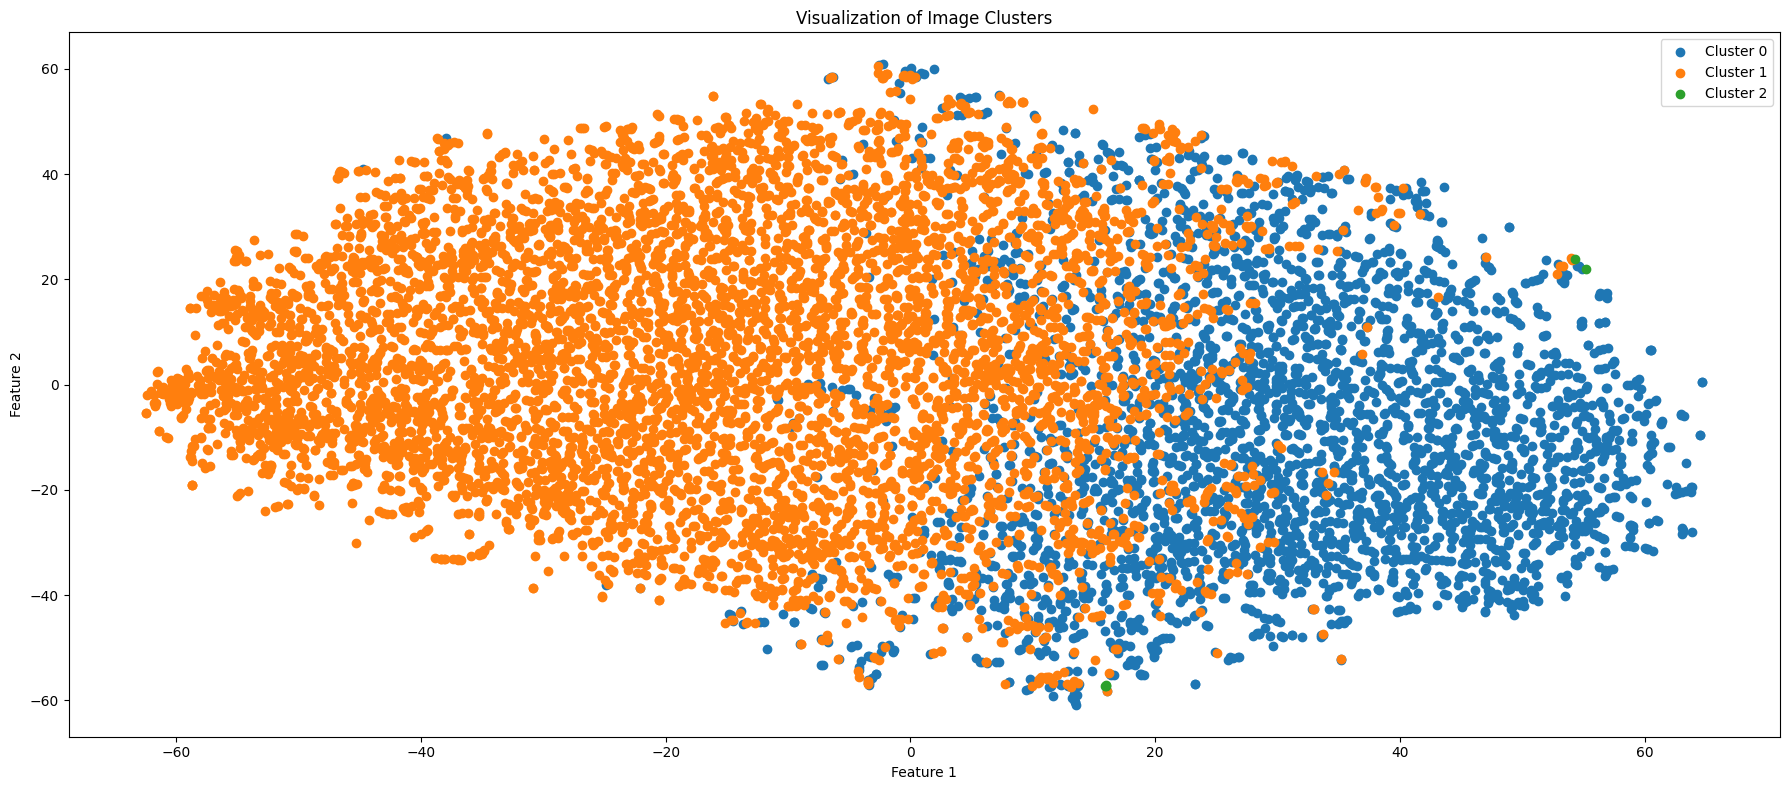

In [24]:
# Appling t-SNE for dimensionality reduction
tsne = TSNE(n_components=2, random_state=42)
embeddings = tsne.fit_transform(features_reduced)

# Setting the figure
plt.figure(figsize=(18, 8))

# Iterating over the clusters
for i in range(3):

    # Getting the images of the current cluster
    cluster_images = np.where(clusters == i)[0]

    # Adding them to the scatter plot
    plt.scatter(
        embeddings[cluster_images, 0],
        embeddings[cluster_images, 1],
        label=f"Cluster {i}",
    )

# Setting some plot parameters
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.title("Visualization of Image Clusters")
plt.legend()

# Showing the plot
plt.tight_layout()
plt.show()

Find the five closest images to the centroid of each cluster and visualise them. These images are the five most representative images per cluster

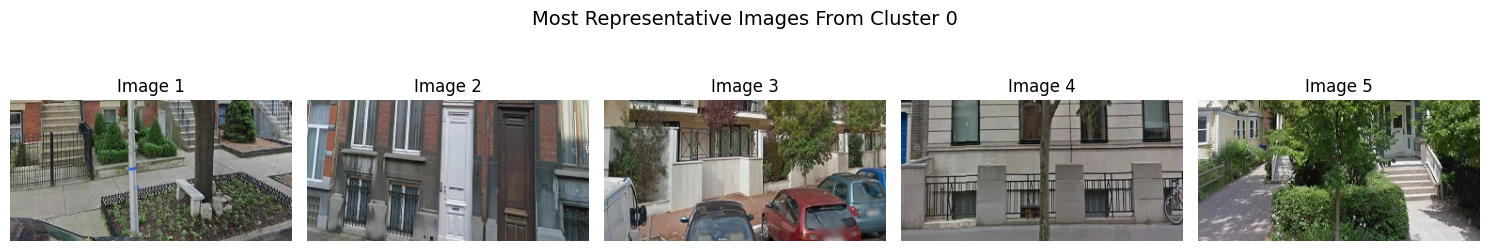

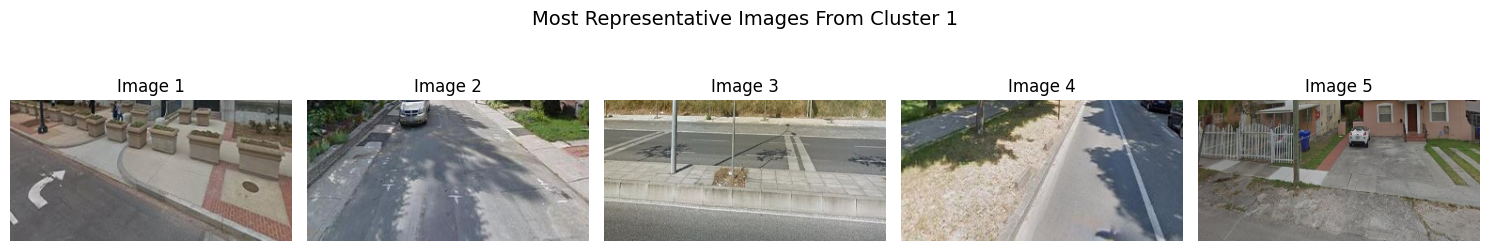

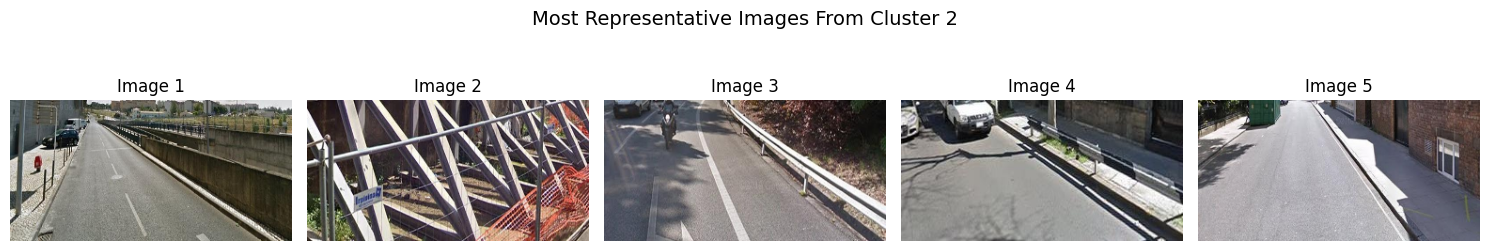

In [21]:
# Iterating over the clusters
for cluster in range(3):

    # Getting the images of the current cluster
    cluster_images = dataset[dataset["cluster"] == cluster][["features", "image"]]

    # Getting the distance of each image from the centroid
    cluster_images["distance"] = cluster_images["features"].apply(
        lambda feature: distance.euclidean(feature, clusters_centroids[cluster])
    )

    # Sorting
    cluster_images = cluster_images.sort_values(by="distance", ascending=True)

    # Creating subplots
    fig, axes = plt.subplots(1, 5, figsize=(15, 3))

    # Iterating over the images
    for i in range(min(5, len(cluster_images))):

        # Displaying the images
        axes[i].imshow(cluster_images["image"].iloc[i])
        axes[i].set_title(f"Image {i + 1}")
        axes[i].axis("off")

    # Adding a title
    plt.suptitle(f"Most Representative Images From Cluster {cluster}", fontsize=14)

    # Showing the figure
    plt.tight_layout()
    plt.show()

Based on the five most representative images for each cluster, below we can see an approximate description of each cluster:

**<u>Cluster 0</u>**
<br>

The images in this cluster appear to focus on residential areas or suburban settings. There is a strong presence of greenery, residential buildings, and well-maintained streets. The images seem to represent areas where the focus is on housing, parks, and local infrastructure, which are more likely residential in nature compared to commercial or heavy urban traffic areas.

**<u>Cluster 1</u>**
<br>
These images depict urban street segments that emphasize paved surfaces, curbs, and sidewalks rather than building fronts. There may be planters, parked cars, and subtle infrastructure elements like utility poles and subtle signage. The focus is on the street-level environment where pedestrians and vehicles share space, but with less architectural detail than in Cluster 0.

**<u>Cluster 2</u>**
<br>
These images show roads and side lanes, often with guardrails, barriers or protective fencing. Buildings are much less prominent, and the emphasis is on linear infrastructure, sometimes with bike lanes, retaining walls or temporary structures. The scenes carry a focus on transportation corridors and structural aspects of roads and trails.

**<u>Conclusion</u>**

Cluster 0: Residential areas with a focus on greenery and housing
<br>
Cluster 1: Street-level spaces with mixed-use infrastructure
<br>
Cluster 2: Roadway corridors and transportation elements

Find the distribution of images in the clusters for each city

In [22]:
# Getting the distribution of images in the clusters for each city
city_image__cluster_distribution = dataset.groupby(
    ["city_id", "cluster"], as_index=False
).agg(total_images=("image", "count"))

# Pivoting
city_image__cluster_distribution = (
    city_image__cluster_distribution.pivot(
        index="city_id", columns="cluster", values="total_images"
    )
    .reset_index()
    .fillna(0)
)

# Removing the index names
city_image__cluster_distribution.columns.name = None

# Getting the percentages
city_image__cluster_distribution.iloc[:, 1:] = (
    city_image__cluster_distribution.iloc[:, 1:].div(
        city_image__cluster_distribution.iloc[:, 1:].sum(axis=1), axis=0
    )
    * 100
)

# Rounding
city_image__cluster_distribution.iloc[:, 1:] = city_image__cluster_distribution.iloc[
    :, 1:
].round(2)

# Sorting
city_image__cluster_distribution = city_image__cluster_distribution.sort_values(
    by=[1, 0, 2]
)

city_image__cluster_distribution

city_id      0      1     2
12    MexicoCity  48.35  51.24  0.41
20          Rome  46.81  52.97  0.22
9         Madrid  46.91  53.09  0.00
4    BuenosAires  43.75  56.25  0.00
22  WashingtonDC  41.74  58.26  0.00
0        Bangkok  41.33  58.67  0.00
1      Barcelona  39.33  60.67  0.00
8     LosAngeles  38.10  61.90  0.00
6         Lisbon  37.38  62.23  0.39
2         Boston  37.66  62.34  0.00
7         London  37.56  62.35  0.09
5        Chicago  36.96  63.04  0.00
3       Brussels  36.19  63.81  0.00
13         Miami  35.44  64.56  0.00
11     Melbourne  31.73  68.27  0.00
10      Medellin  30.70  69.30  0.00
17           PRG  29.82  70.18  0.00
18           PRS  29.67  70.33  0.00
16         Osaka  28.81  71.19  0.00
14   Minneapolis  27.25  72.75  0.00
19       Phoenix  26.42  73.58  0.00
15           OSL  26.09  73.91  0.00
21           TRT  17.01  82.99  0.00

Visualize the distribution

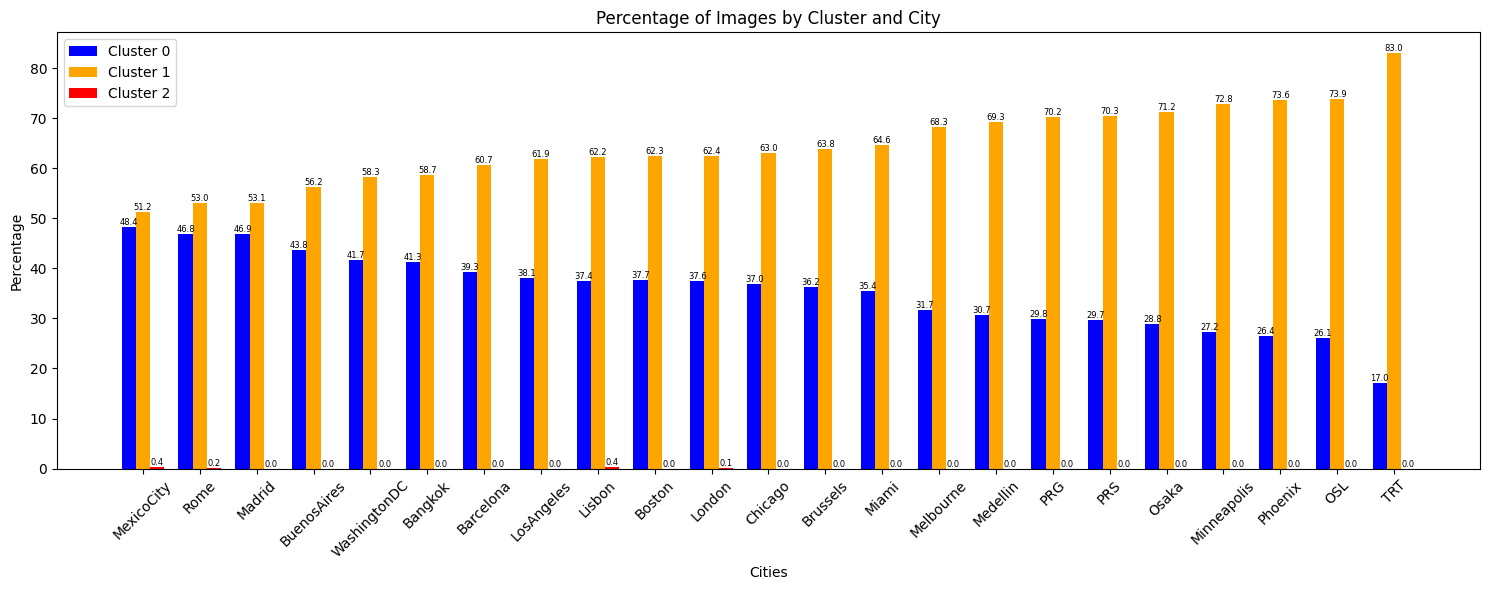

In [23]:
# Getting a range from 0 until the total cities
city_range = np.arange(len(city_image__cluster_distribution["city_id"]))

# Setting the width of bars
bar_width = 0.25

# Setting the figure and axes
fig, ax = plt.subplots(figsize=(15, 6))

# Plotting the bars
bars_0 = ax.bar(
    city_range - bar_width,
    city_image__cluster_distribution[0],
    bar_width,
    label="Cluster 0",
    color="blue",
)
bars_1 = ax.bar(
    city_range,
    city_image__cluster_distribution[1],
    bar_width,
    label="Cluster 1",
    color="orange",
)
bars_2 = ax.bar(
    city_range + bar_width,
    city_image__cluster_distribution[2],
    bar_width,
    label="Cluster 2",
    color="red",
)

# Adding labels, title, and legend
ax.set_xlabel("Cities")
ax.set_ylabel("Percentage")
ax.set_title("Percentage of Images by Cluster and City")
ax.set_xticks(city_range)
ax.set_xticklabels(city_image__cluster_distribution["city_id"])
ax.legend()
plt.xticks(rotation=45)


def add_values(bars):
    """
    This function used to add values to the bars of the plot.

    :param bars: The bars to add values to.
    """

    # Iterating over the bars
    for bar in bars:

        # Getting the height
        height = bar.get_height()

        # Adding the bar value
        ax.text(
            bar.get_x() + bar.get_width() / 2,
            height,
            f"{height:.1f}",
            ha="center",
            va="bottom",
            fontsize=6,
        )


# Adding values to the bars
add_values(bars_0)
add_values(bars_1)
add_values(bars_2)

# Displaying the plot
plt.tight_layout()
plt.show()

Based on the above results, there are certain groups of cities in which the cities included are more similar in terms of cluster assignment. Below, we can see the corresponding groups:

- MexicoCity - Madrid - Rome
- Buenos Aires - WashingtonDC - Bangkok
- Barcelona - LosAngeles - Lisbon - Boston - London - Chicago - Brussels - Miami
- Melbourne - Medelin - PRG - PRS - Osaka
- Mineapolis - Phoenix - OSL

Cities with very similar percentages are grouped together, while the only city whose distribution is very different is TRT

##### **Conclusion**

Task 1: In Task 1 we saw that the Kaggle dataset has two folders, one containing images of different cities and the other containing metadata about those images. The distribution of images across cities is different and there is not an equal number of images for all cities. Also, each city contains many places with most of the time more than one image per place. In particular, there are 23 cities and 529.506 images. The dimensions of the images are (300, 400) or (480, 640). To proceed, I decided to resize the images to (300,150) and keep only the middle-bottom part of the images and focus my analysis there.

Task 2: In Task 2 we conduct data analysis to gain more insights into the data. The analyses performed are as follows:

1. Total unique places
2. Total unique places and records for each city
3. Total number of places appeared more than once and statistic metrics for their coordinates
4. Statistical measurements for the coordinates of each city
5. Max and min number of images per place
6. The shortest and longest pair of places for each city
7. The distribution of the images over the years and cities
8. The different levels of image brightness in the cities

Task 3: In Task 3 we use the final dataset from Task 1 to apply the KMeans algorithm and cluster the images. I chose the value 3 for the K parameter as it gives more information to the clustering process by keeping the silhouette value at a high level compared to the other values and I get three groups with the titles:
- cluster 0:Residential areas with a focus on greenery and housing
- cluster 1: Street-level spaces with mixed-use infrastructure
- cluster 2: Roadway corridors and transportation elements

Finally, we found that there are some groups of cities that are more similar than others based on the distribution of their images in the clusters


The biggest limitation and the biggest obstacle in my analyses was the size of the original dataset which ι had to handle accordingly in order to keep within my computational capabilities. Because of this, data had to be removed and not all of it was taken during the various analysis processes. It is very likely that if we used all the data we would have different outcomes and conclusions.


### **Part 3 - End Application**

Load all the provided images

In [25]:
# Connecting to drive
drive.mount("/content/drive")

# Setting the path for the images
folder_path_images = "/content/drive/My Drive/Photos for Capcha"

# Getting all the images files
images_files = os.listdir(folder_path_images)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Get their drive id to use it to link to the annotation files and read them in RGB format.

In [26]:
# Authedicating
auth.authenticate_user()

# Setting up  the Google Drive API client
drive_service = build("drive", "v3")

# Setting up a dictionary to store the results
images_dic = {}

# Iterating over the images
for image_file in images_files:

    # Quering to get the id of the image
    results = (
        drive_service.files()
        .list(q=f"mimeType='image/jpeg' and name='{image_file}'", fields="files(id)")
        .execute()
    )
    image_id = results.get("files", [])

    # Reading the image
    image = cv2.imread(f"{folder_path_images}/{image_file}")

    # Getting the rgb representation of the image
    images_dic[image_id[0]["id"]] = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Converting to a dataframe
images_df = pd.DataFrame(list(images_dic.items()), columns=["image_id", "image_rgb"])

# Sorting
images_df.sort_values(by="image_id", inplace=True, ignore_index=True)

images_df.head(2)

image_id  \
0  107Dvcguof1PyOeBSLYAwGDAW3wjCGkew   
1  116VN7qiC55h4DOcAU6MWAZFGiUVX50OZ   

                                           image_rgb  
0  [[[23, 28, 32], [23, 28, 32], [22, 27, 31], [1...  
1  [[[115, 122, 114], [113, 120, 112], [114, 124,...

Show the first three images

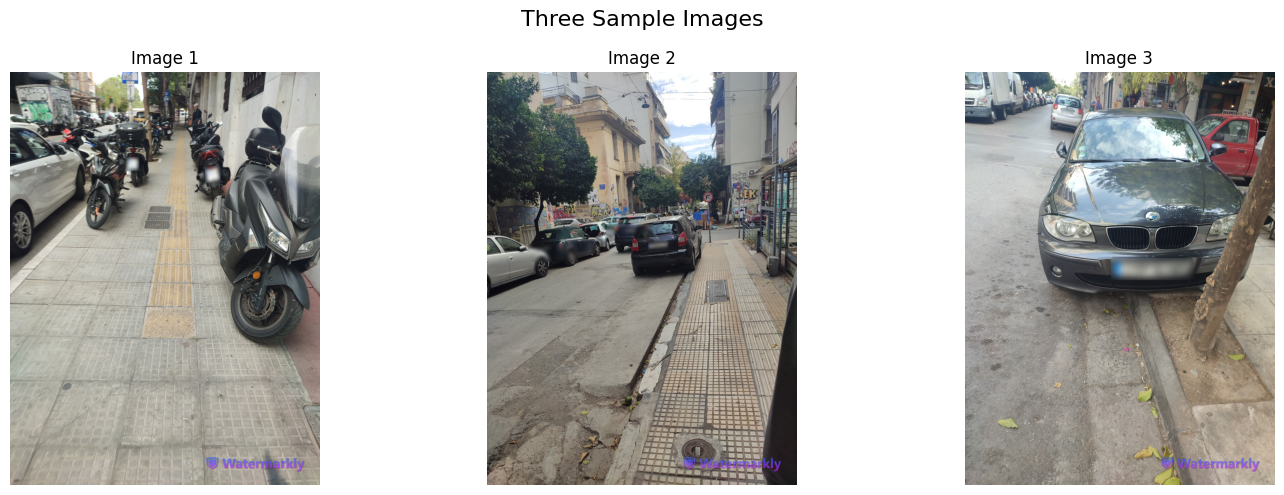

In [27]:
# Creating subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Displaing the images
axes[0].imshow(images_df["image_rgb"][0])
axes[0].set_title("Image 1")
axes[0].axis("off")

axes[1].imshow(images_df["image_rgb"][1])
axes[1].set_title("Image 2")
axes[1].axis("off")

axes[2].imshow(images_df["image_rgb"][2])
axes[2].set_title("Image 3")
axes[2].axis("off")

# Adding a title
plt.suptitle("Three Sample Images", fontsize=16)

# Showing the figure
plt.tight_layout()
plt.show()

We see that there are two different image dimensions

In [28]:
# Extracting features for the images
images_df["image_rgb"].apply(lambda image: image.shape).unique()

array([(4000, 3000, 3), (3000, 4000, 3)], dtype=object)

Extract features from the images using again the 'VGG16' model

In [30]:
# Extracting features for the images
athens_images_features = extract_features(model, images_df["image_rgb"].tolist())

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step


Normalize and reduce the dimensionality

In [31]:
# Normalizing the features
scaler = StandardScaler()
athens_images_features_normalized = scaler.fit_transform(athens_images_features)

# Appling PCA to reduce the dimensionality of the features
pca = PCA(n_components=124, random_state=42)
athens_images_features_reduced = pca.fit_transform(athens_images_features_normalized)

Get the cluster for each image using the already trained model

In [32]:
# Getting the clusters
athens_images_clusters = kmeans_model.predict(athens_images_features_reduced)

# Storing
images_df["clusters"] = athens_images_clusters

Find the distribution of the images in the clusters

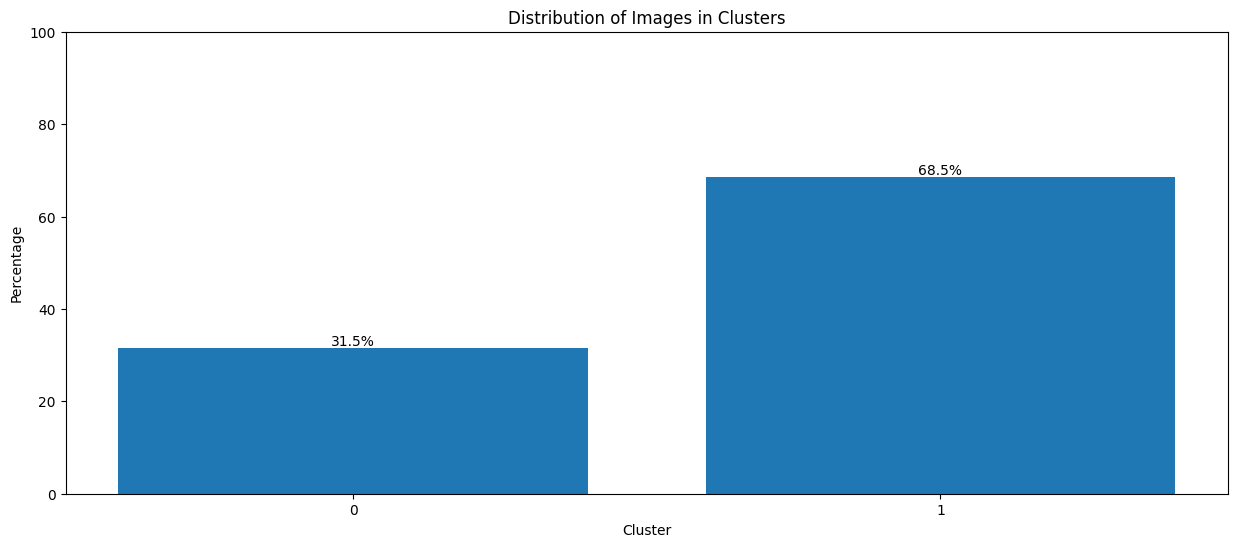

In [34]:
# Getting the percentages
unique, counts = np.unique(athens_images_clusters, return_counts=True)
percentages = {
    value: round((count / 124) * 100, 1) for value, count in zip(unique, counts)
}

# Setting the figure
fig = plt.figure(figsize=(15, 6))

# Setting the bars
bars = plt.bar(list(percentages.keys()), list(percentages.values()))

# Plotting
plt.xlabel("Cluster")
plt.ylabel("Percentage")
plt.title("Distribution of Images in Clusters")
plt.xticks(list(percentages.keys()))
plt.ylim(0, 100)

# Adding bar values
for bar in bars:

    # Getting the height
    height = bar.get_height()

    # Adding
    plt.text(
        bar.get_x() + bar.get_width() / 2.0,
        height,
        f"{height}%",
        ha="center",
        va="bottom",
    )

# Displaying
plt.show()

Find the three cities that look most like Athens from part 2 based on the distribution of the images in the groups. Calculate the distance of all pairs (cluster 0, cluster 1) from the current distribution for clusters 0 and 1 and keep the three smallest

In [36]:
# Getting the indices of the three most similar cities
indices = (
    city_image__cluster_distribution.apply(
        lambda row: distance.euclidean(
            (row[0], row[1]), (percentages[0], percentages[1])
        ),
        axis=1,
    )
    .sort_values(ascending=True)
    .head(3)
    .index
)

print(
    "The three most similar cities to Athens based on the image distribution across clusters are:\n",
    city_image__cluster_distribution.loc[indices, "city_id"].tolist(),
)

The three most similar cities to Athens based on the image distribution across clusters are:
 ['Melbourne', 'Medellin', 'PRG']


Now, in order to proceed we will process the annotation files

Create a final annotation dataframe containing two index columns that are the image ids and labels, and also a per annotator column containing the annotations. I decided to include the Other label which will take the value 1 if someone wrote a new type of observation on the images instead of using the default categories and zero otherwise. In addition, I assumed that the None option was not a specific label and suggests that the annotator did not know what to choose.

Also, in order to describe the level of difficulty of the annotation task, I decided to quantify and show how many times the annotators could not give at least one category to the images and mainly chose nothing or chose the option None.

In [37]:
# Setting the path for the annotations
folder_path_annotations = "/content/drive/My Drive/student"

# Getting all the annotation files
annotations_files = os.listdir(folder_path_annotations)

# Get default credentials
creds, _ = default()

# Authorize gspread
gc = gspread.authorize(creds)

# Setting the used labels
labels = [
    "Parked Vehicles Obstructing Sidewalks",
    "Narrow or Limited Sidewalk Space",
    "Uneven or Hazardous Pavement",
    "Obstacles from Natural Elements",
    "Miscellaneous Obstructions",
    "Blocked or Limited Crossing Access",
    "Debris and Environmental Hazards",
    "Other",
]

# Setting up a dictionary to hold the number of times each annotator was not able to annotate
unable_to_annotate = {}

# Initializing an empty dataframe to store all the annotations
annotations = pd.DataFrame()

# Setting an idicator for the number of parsed files
number_of_files = 0

# Iterating over the annotations files
for annotation_file in annotations_files:

    # Updating the number of the parsed valid file
    number_of_files += 1

    # Getting the annotator
    annotator = annotation_file.split(".")[0]

    # Opening the file
    gsheet = gc.open(annotator)

    # Getting the first sheet
    sheet = gsheet.sheet1

    # Converting to a dataframe
    annotation = get_as_dataframe(sheet, header=1)

    # Removing all the NaN values
    annotation.dropna(how="all", inplace=True)

    # Getting specific columns
    annotation_new = annotation[["Image URL ", "Categorie", "Other..."]].copy()

    # Getting the drive id of images
    annotation_new.insert(
        1,
        "image_id",
        annotation_new["Image URL "].apply(lambda row: row.split("id=")[1]),
    )

    # Getting the total times was not able to annotate
    unable_to_annotate[annotator] = annotation_new["Categorie"].isna().sum()

    # Iterating over the labels
    for label in labels:

        # Checking the type of label
        if label != "Other":

            # Marking if the label is selected or not
            annotation_new[label] = annotation_new["Categorie"].apply(
                lambda row: 0 if pd.isna(row) else (1 if label in row else 0)
            )

        else:

            # Marking if the label is selected or not
            annotation_new[label] = annotation_new["Other..."].apply(
                lambda row: 0 if pd.isna(row) else 1
            )

    # Dropping
    annotation_new.drop(columns=["Image URL ", "Categorie", "Other..."], inplace=True)

    # Sorting
    annotation_new.sort_values(by="image_id", inplace=True, ignore_index=True)

    annotation_new = annotation_new.melt(
        id_vars=["image_id"], var_name="label", value_name="value"
    )

    # Checking if the parsed file is the first one
    if number_of_files == 1:

        # Updating
        annotations[["image_id", "label"]] = annotation_new[["image_id", "label"]]

    # Getting the annotations per image
    annotations[annotator] = annotation_new["value"]


# Setting as index the "image_id" and "label" columns
annotations.set_index(["image_id", "label"], inplace=True)

annotations.head(5)

f3352409  \
image_id                          label                                             
107Dvcguof1PyOeBSLYAwGDAW3wjCGkew Parked Vehicles Obstructing Sidewalks         1   
116VN7qiC55h4DOcAU6MWAZFGiUVX50OZ Parked Vehicles Obstructing Sidewalks         1   
11h5fnIDQUkEHBQUhLASVO8kgrLfjzWIz Parked Vehicles Obstructing Sidewalks         1   
123WeyBbgG5oX8wIAFL4aIgV-6DWxiWzo Parked Vehicles Obstructing Sidewalks         1   
13212aJnDCbKmv8dYr88LhmiaLT9xqmjh Parked Vehicles Obstructing Sidewalks         0   

                                                                         f3210105  \
image_id                          label                                             
107Dvcguof1PyOeBSLYAwGDAW3wjCGkew Parked Vehicles Obstructing Sidewalks         0   
116VN7qiC55h4DOcAU6MWAZFGiUVX50OZ Parked Vehicles Obstructing Sidewalks         0   
11h5fnIDQUkEHBQUhLASVO8kgrLfjzWIz Parked Vehicles Obstructing Sidewalks         0   
123WeyBbgG5oX8wIAFL4aIgV-6DWxiWzo Parked Vehicles Obstructing Sidewalks         0   
13212aJnDCbKmv8dYr88LhmiaLT9xqmjh Parked Vehicles Obstructing Sidewalks         0   

                                                                         f3352410  \
image_id                          label                                             
107Dvcguof1PyOeBSLYAwGDAW3wjCGkew Parked Vehicles Obstructing Sidewalks         1   
116VN7qiC55h4DOcAU6MWAZFGiUVX50OZ Parked Vehicles Obstructing Sidewalks         0   
11h5fnIDQUkEHBQUhLASVO8kgrLfjzWIz Parked Vehicles Obstructing Sidewalks         0   
123WeyBbgG5oX8wIAFL4aIgV-6DWxiWzo Parked Vehicles Obstructing Sidewalks         1   
13212aJnDCbKmv8dYr88LhmiaLT9xqmjh Parked Vehicles Obstructing Sidewalks         1   

                                                                         f3352407  \
image_id                          label                                             
107Dvcguof1PyOeBSLYAwGDAW3wjCGkew Parked Vehicles Obstructing Sidewalks         1   
116VN7qiC55h4DOcAU6MWAZFGiUVX50OZ Parked Vehicles Obstructing Sidewalks         0   
11h5fnIDQUkEHBQUhLASVO8kgrLfjzWIz Parked Vehicles Obstructing Sidewalks         1   
123WeyBbgG5oX8wIAFL4aIgV-6DWxiWzo Parked Vehicles Obstructing Sidewalks         1   
13212aJnDCbKmv8dYr88LhmiaLT9xqmjh Parked Vehicles Obstructing Sidewalks         1   

                                                                         f3352402  \
image_id                          label                                             
107Dvcguof1PyOeBSLYAwGDAW3wjCGkew Parked Vehicles Obstructing Sidewalks         0   
116VN7qiC55h4DOcAU6MWAZFGiUVX50OZ Parked Vehicles Obstructing Sidewalks         0   
11h5fnIDQUkEHBQUhLASVO8kgrLfjzWIz Parked Vehicles Obstructing Sidewalks         0   
123WeyBbgG5oX8wIAFL4aIgV-6DWxiWzo Parked Vehicles Obstructing Sidewalks         0   
13212aJnDCbKmv8dYr88LhmiaLT9xqmjh Parked Vehicles Obstructing Sidewalks         1   

                                                                         f3352406  \
image_id                          label                                             
107Dvcguof1PyOeBSLYAwGDAW3wjCGkew Parked Vehicles Obstructing Sidewalks         1   
116VN7qiC55h4DOcAU6MWAZFGiUVX50OZ Parked Vehicles Obstructing Sidewalks         0   
11h5fnIDQUkEHBQUhLASVO8kgrLfjzWIz Parked Vehicles Obstructing Sidewalks         1   
123WeyBbgG5oX8wIAFL4aIgV-6DWxiWzo Parked Vehicles Obstructing Sidewalks         1   
13212aJnDCbKmv8dYr88LhmiaLT9xqmjh Parked Vehicles Obstructing Sidewalks         0   

                                                                         f3352401  \
image_id                          label                                             
107Dvcguof1PyOeBSLYAwGDAW3wjCGkew Parked Vehicles Obstructing Sidewalks         1   
116VN7qiC55h4DOcAU6MWAZFGiUVX50OZ Parked Vehicles Obstructing Sidewalks         0   
11h5fnIDQUkEHBQUhLASVO8kgrLfjzWIz Parked Vehicles Obstructing Sidewalks         1   
123WeyBbgG5oX8wIAFL4aIgV-6DWxiWzo Parked Vehicles Obstructing Sidewalks 

Visualisation of the distribution of untagged images among annotators

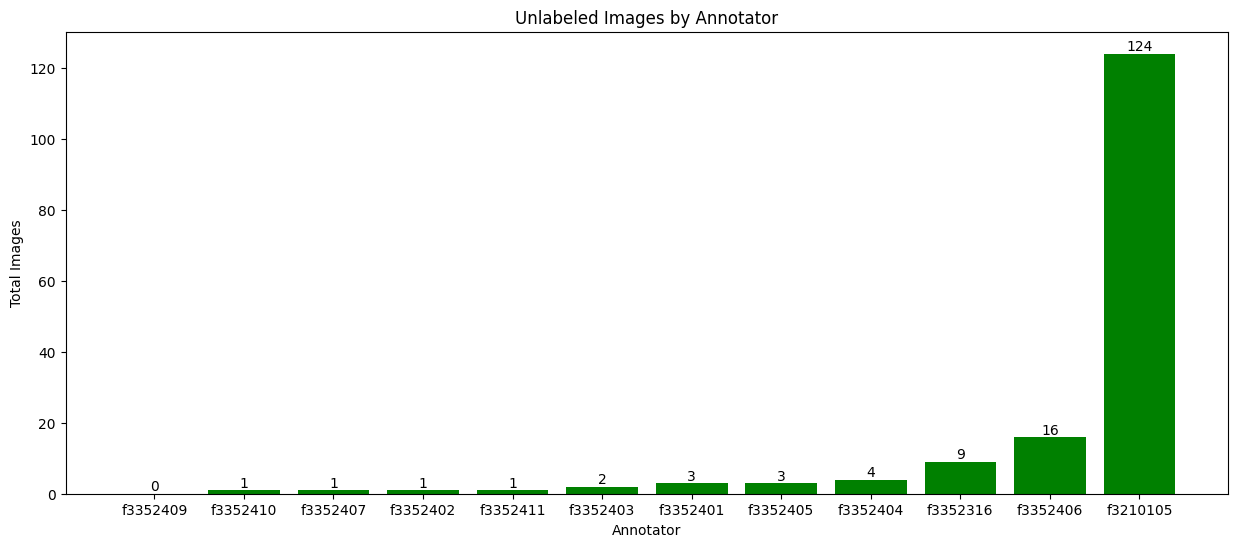

In [38]:
# Sorting
unable_to_annotate = dict(sorted(unable_to_annotate.items(), key=lambda item: item[1]))

# Setting up the figure
plt.figure(figsize=(15, 6))

# Create the bar chart
bars = plt.bar(
    list(unable_to_annotate.keys()), list(unable_to_annotate.values()), color="green"
)

# Add labels and title (optional)
plt.xlabel("Annotator")
plt.ylabel("Total Images")
plt.title("Unlabeled Images by Annotator")

for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2, height, str(height), ha="center", va="bottom"
    )

# Show the plot
plt.show()

From the above diagram and the results that follow, we can see that the most common case is that an annotator failed to label only one image, while there is an extreme case where an annotator could not label anything, which probably means that did not try at all. Considering this outlier, the average number of unlabeled images per annotator is about 14, which is not very representative due to this large difference in correlation with the other cases. Because of this, the median gives a clearer picture, indicating that most annotators have relatively few unlabeled images, especially around 3. Except for the extreme case, in general the difficulty of the task is low to slightly difficult due to the existence of values close to 10 and a little above.

In [40]:
# Calculating the mean and median
unlabeled_images_mean = np.mean(list(unable_to_annotate.values()))
unlabeled_images_median = np.median(list(unable_to_annotate.values()))

print("The average number of unlabeled images: ", unlabeled_images_mean)
print("The median value of unlabeled images: ", unlabeled_images_median)

The average number of unlabeled images:  13.75
The median value of unlabeled images:  2.5


Calculate the probability of each label per annotator. To do that, we need to find the total number of unique images included in the annotated dataset and how many times each label has been used. This must be done for each annotator. To achive this, we will follow the formula below:


$$
P(Label) = \frac{\text{Number of times label is } 1}{\text{Total number of images}}
$$

In [41]:
# Finding the total images
total_images = annotations.index.get_level_values("image_id").nunique()

# Calculating the probabilities per label and annotator
label_probabilities = annotations.apply(
    lambda column: column.groupby(level="label").agg(
        lambda x: (x.sum() / total_images).round(2)
    ),
    axis=0,
)

label_probabilities

f3352409  f3210105  f3352410  f3352407  \
label                                                                           
Blocked or Limited Crossing Access         0.15       0.0      0.31      0.15   
Debris and Environmental Hazards           0.11       0.0      0.50      0.06   
Miscellaneous Obstructions                 0.06       0.0      0.16      0.02   
Narrow or Limited Sidewalk Space           0.15       0.0      0.67      0.48   
Obstacles from Natural Elements            0.09       0.0      0.55      0.18   
Other                                      0.00       0.0      0.00      0.00   
Parked Vehicles Obstructing Sidewalks      0.56       0.0      0.71      0.73   
Uneven or Hazardous Pavement               0.02       0.0      0.18      0.15   

                                       f3352402  f3352406  f3352401  f3352316  \
label                                                                           
Blocked or Limited Crossing Access         0.13      0.31      0.24      0.19   
Debris and Environmental Hazards           0.40      0.31      0.39      0.27   
Miscellaneous Obstructions                 0.12      0.04      0.06      0.02   
Narrow or Limited Sidewalk Space           0.43      0.20      0.65      0.42   
Obstacles from Natural Elements            0.60      0.06      0.35      0.18   
Other                                      0.00      0.00      0.00      0.02   
Parked Vehicles Obstructing Sidewalks      0.38      0.65      0.65      0.48   
Uneven or Hazardous Pavement               0.15      0.04      0.15      0.10   

                                       f3352403  f3352404  f3352405  f3352411  
label                                                                          
Blocked or Limited Crossing Access         0.25      0.12      0.10      0.19  
Debris and Environmental Hazards           0.40      0.21      0.42      0.49  
Miscellaneous Obstructions                 0.06      0.09      0.09      0.46  
Narrow or Limited Sidewalk Space           0.69      0.56      0.83      0.65  
Obstacles from Natural Elements            0.15      0.27      0.54      0.52  
Other                                      0.00      0.00      0.00      0.00  
Parked Vehicles Obstructing Sidewalks      0.34      0.61      0.22      0.90  
Uneven or Hazardous Pavement               0.23      0.26      0.12      0.48

To visualize the probabilities, we will use a heatmap, which facilitates the identification of patterns and variations in the annotations by label

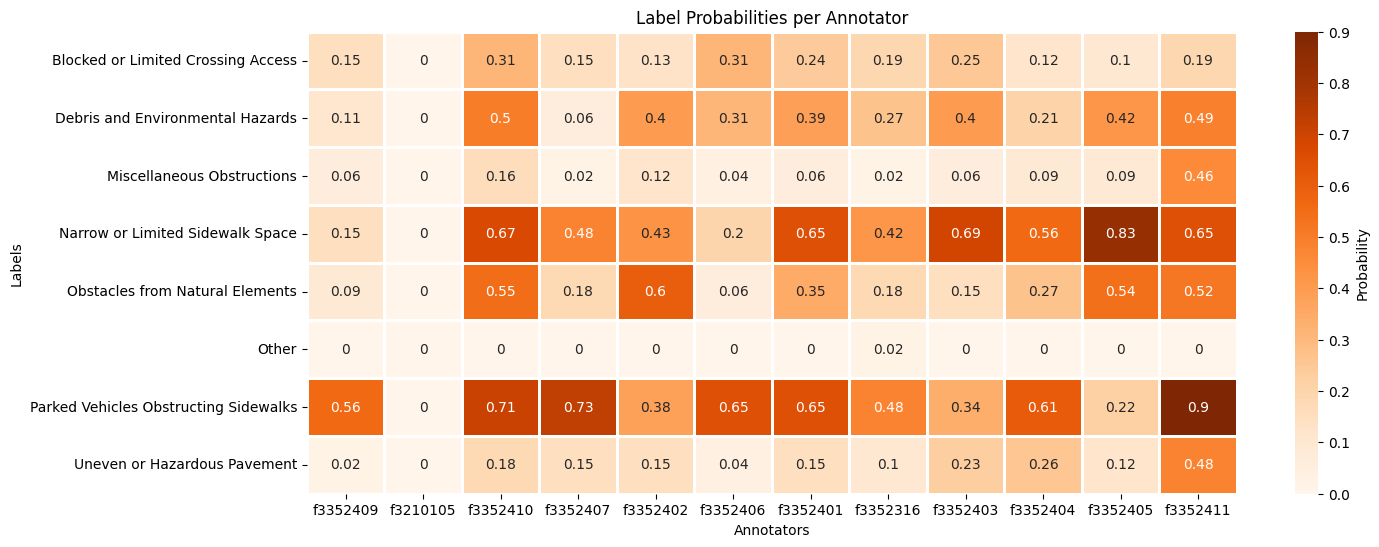

In [42]:
# Setting up the figure
plt.figure(figsize=(15, 6))

# Creating the heatmap showing the probabilities
sns.heatmap(
    label_probabilities,
    annot=True,
    cmap="Oranges",
    cbar_kws={"label": "Probability"},
    linewidths=2,
)

# Adding title and labels
plt.title("Label Probabilities per Annotator")
plt.xlabel("Annotators")
plt.ylabel("Labels")

# Showing the plot
plt.show()

It is useful to note that there is only one annotator who selects the "Other" tag and there are also two annotators who show a very high preference for the "Narrow or limited sidewalk space" (f3352405 - 0.83) and "Parked vehicles blocking sidewalks" (f3352411 - 0.9) tags.

Compute the Inter-Annotator Agreement based on the Cohen's kappa metric

In [43]:
# Setting up a dictionary to store the the kappa metric for each pair of annotators
kappa_agreement = {a: {} for a in annotations.columns}

# Iterating over the columns of the 'annotations' dataframe
for column_1 in annotations.columns:

    # Iterating again over the columns of the 'annotations' dataframe to get the pairs
    for column_2 in annotations.columns:

        # Checking if the annotators are different or not and calculating the kappa metric
        if column_1 == column_2:
            kappa_agreement[column_1][column_2] = 1
        else:
            kappa_agreement[column_1][column_2] = (
                annotations[[column_1, column_2]]
                .groupby(level="label")
                .apply(lambda group: kappa(group[column_1], group[column_2]))
                .mean()
                .round(2)
            )

# Transforming the dictionary to dataframe
kappa_agreement_df = pd.DataFrame.from_dict(kappa_agreement)

# Printing the inter-annotator agreement
print(
    "The Inter-Annonator Agreement for all the pairs of annotators based on the Cohen's kappa metric:"
)
display(kappa_agreement_df)

The Inter-Annonator Agreement for all the pairs of annotators based on the Cohen's kappa metric:


f3352409  f3210105  f3352410  f3352407  f3352402  f3352406  \
f3352409      1.00       0.0      0.13      0.26      0.19      0.27   
f3210105      0.00       1.0      0.00      0.00      0.00      0.00   
f3352410      0.13       0.0      1.00      0.25      0.29      0.24   
f3352407      0.26       0.0      0.25      1.00      0.19      0.34   
f3352402      0.19       0.0      0.29      0.19      1.00      0.17   
f3352406      0.27       0.0      0.24      0.34      0.17      1.00   
f3352401      0.26       0.0      0.27      0.28      0.31      0.42   
f3352316      0.28       0.0      0.25      0.22      0.28      0.34   
f3352403      0.29       0.0      0.26      0.20      0.43      0.35   
f3352404      0.17       0.0      0.19      0.23      0.24      0.27   
f3352405      0.21       0.0      0.38      0.22      0.43      0.29   
f3352411      0.15       0.0      0.31      0.21      0.35      0.26   

          f3352401  f3352316  f3352403  f3352404  f3352405  f3352411  
f3352409      0.26      0.28      0.29      0.17      0.21      0.15  
f3210105      0.00      0.00      0.00      0.00      0.00      0.00  
f3352410      0.27      0.25      0.26      0.19      0.38      0.31  
f3352407      0.28      0.22      0.20      0.23      0.22      0.21  
f3352402      0.31      0.28      0.43      0.24      0.43      0.35  
f3352406      0.42      0.34      0.35      0.27      0.29      0.26  
f3352401      1.00      0.28      0.36      0.37      0.33      0.41  
f3352316      0.28      1.00      0.39      0.24      0.29      0.27  
f3352403      0.36      0.39      1.00      0.23      0.39      0.31  
f3352404      0.37      0.24      0.23      1.00      0.27      0.31  
f3352405      0.33      0.29      0.39      0.27      1.00      0.32  
f3352411      0.41      0.27      0.31      0.31      0.32      1.00

The Inter-Annotator Agreement based on Cohen's kappa is a good metric and shows valuable information about how much the annotators agree and also takes into account the possibility the annotators agree randomly. As we can see above in most cases the Inter-Annotator Agreement gets lower values which is perfectly reasonable because it includes the probability of random agreement that reduces the agreement between annotators. In general, the Cohen's kappa metric gives a more accurate and clear view about how much the annotators agree.

Visualize the above Inter-Annotator Agreement

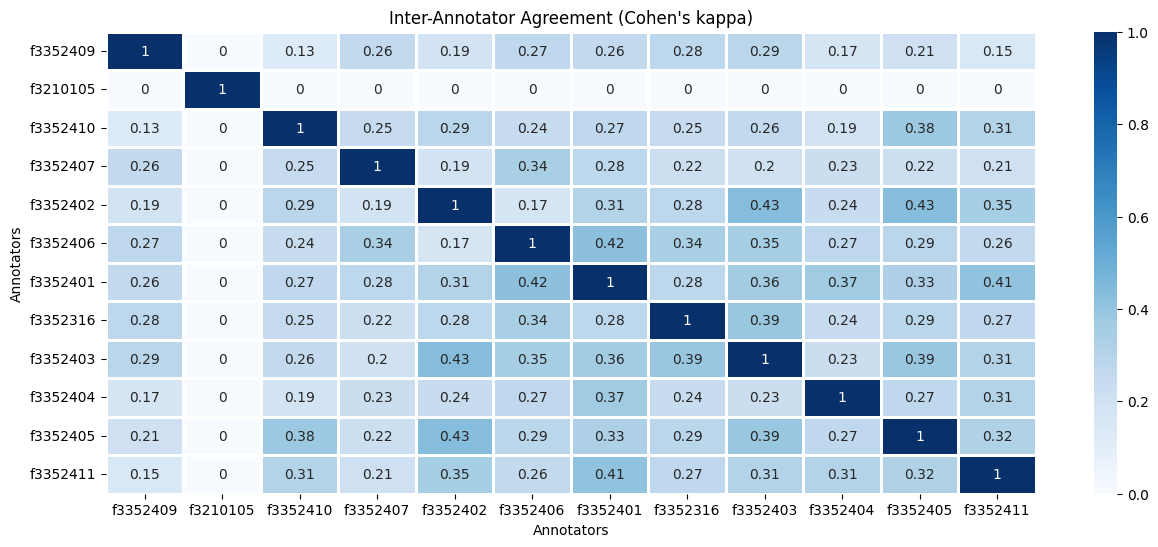

In [44]:
# Setting up the figure
plt.figure(figsize=(15, 6))

# Creating the heatmap showing the inter-annotator agreement for all the pairs of annotators
sns.heatmap(kappa_agreement_df, annot=True, cmap="Blues", linewidths=2)

# Adding title and labels
plt.title("Inter-Annotator Agreement (Cohen's kappa)")
plt.xlabel("Annotators")
plt.ylabel("Annotators")

# Showing the plot
plt.show()

In order to proceed, i will compute the ground truth value per image and label. To do this, i will find the average annotation per image per label and round it to the nearest integer

In [45]:
# Taking the average annotation per image and label
average_per_image_label = annotations.mean(1)

# Creating a new dataframe with the ground truth per image and label
ground_truth_df = pd.DataFrame(
    {
        "average": average_per_image_label,
        "ground_truth": average_per_image_label.apply(lambda row: round(row)),
    }
)

ground_truth_df.head(5)

average  \
image_id                          label                                             
107Dvcguof1PyOeBSLYAwGDAW3wjCGkew Parked Vehicles Obstructing Sidewalks  0.583333   
116VN7qiC55h4DOcAU6MWAZFGiUVX50OZ Parked Vehicles Obstructing Sidewalks  0.166667   
11h5fnIDQUkEHBQUhLASVO8kgrLfjzWIz Parked Vehicles Obstructing Sidewalks  0.666667   
123WeyBbgG5oX8wIAFL4aIgV-6DWxiWzo Parked Vehicles Obstructing Sidewalks  0.583333   
13212aJnDCbKmv8dYr88LhmiaLT9xqmjh Parked Vehicles Obstructing Sidewalks  0.333333   

                                                                         ground_truth  
image_id                          label                                                
107Dvcguof1PyOeBSLYAwGDAW3wjCGkew Parked Vehicles Obstructing Sidewalks             1  
116VN7qiC55h4DOcAU6MWAZFGiUVX50OZ Parked Vehicles Obstructing Sidewalks             0  
11h5fnIDQUkEHBQUhLASVO8kgrLfjzWIz Parked Vehicles Obstructing Sidewalks             1  
123WeyBbgG5oX8wIAFL4aIgV-6DWxiWzo Parked Vehicles Obstructing Sidewalks             1  
13212aJnDCbKmv8dYr88LhmiaLT9xqmjh Parked Vehicles Obstructing Sidewalks             0

Thus, the final dataset containing the ground truth values will be as follows

In [46]:
# Constructing the final dataset with the ground truth values per image and label
final_images_labels = ground_truth_df["ground_truth"].unstack()

# Removing indices names
final_images_labels.columns.name = None

final_images_labels.head(5)

Blocked or Limited Crossing Access  \
image_id                                                                
107Dvcguof1PyOeBSLYAwGDAW3wjCGkew                                   0   
116VN7qiC55h4DOcAU6MWAZFGiUVX50OZ                                   0   
11h5fnIDQUkEHBQUhLASVO8kgrLfjzWIz                                   0   
123WeyBbgG5oX8wIAFL4aIgV-6DWxiWzo                                   0   
13212aJnDCbKmv8dYr88LhmiaLT9xqmjh                                   1   

                                   Debris and Environmental Hazards  \
image_id                                                              
107Dvcguof1PyOeBSLYAwGDAW3wjCGkew                                 0   
116VN7qiC55h4DOcAU6MWAZFGiUVX50OZ                                 1   
11h5fnIDQUkEHBQUhLASVO8kgrLfjzWIz                                 0   
123WeyBbgG5oX8wIAFL4aIgV-6DWxiWzo                                 0   
13212aJnDCbKmv8dYr88LhmiaLT9xqmjh                                 1   

                                   Miscellaneous Obstructions  \
image_id                                                        
107Dvcguof1PyOeBSLYAwGDAW3wjCGkew                           0   
116VN7qiC55h4DOcAU6MWAZFGiUVX50OZ                           0   
11h5fnIDQUkEHBQUhLASVO8kgrLfjzWIz                           0   
123WeyBbgG5oX8wIAFL4aIgV-6DWxiWzo                           0   
13212aJnDCbKmv8dYr88LhmiaLT9xqmjh                           0   

                                   Narrow or Limited Sidewalk Space  \
image_id                                                              
107Dvcguof1PyOeBSLYAwGDAW3wjCGkew                                 1   
116VN7qiC55h4DOcAU6MWAZFGiUVX50OZ                                 0   
11h5fnIDQUkEHBQUhLASVO8kgrLfjzWIz                                 1   
123WeyBbgG5oX8wIAFL4aIgV-6DWxiWzo                                 0   
13212aJnDCbKmv8dYr88LhmiaLT9xqmjh                                 0   

                                   Obstacles from Natural Elements  Other  \
image_id                                                                    
107Dvcguof1PyOeBSLYAwGDAW3wjCGkew                                0      0   
116VN7qiC55h4DOcAU6MWAZFGiUVX50OZ                                0      0   
11h5fnIDQUkEHBQUhLASVO8kgrLfjzWIz                                0      0   
123WeyBbgG5oX8wIAFL4aIgV-6DWxiWzo                                0      0   
13212aJnDCbKmv8dYr88LhmiaLT9xqmjh                                0      0   

                                   Parked Vehicles Obstructing Sidewalks  \
image_id                                                                   
107Dvcguof1PyOeBSLYAwGDAW3wjCGkew                                      1   
116VN7qiC55h4DOcAU6MWAZFGiUVX50OZ                                      0   
11h5fnIDQUkEHBQUhLASVO8kgrLfjzWIz                                      1   
123WeyBbgG5oX8wIAFL4aIgV-6DWxiWzo                                      1   
13212aJnDCbKmv8dYr88LhmiaLT9xqmjh                                      0   

                                   Uneven or Hazardous Pavement  
image_id                                                         
107Dvcguof1PyOeBSLYAwGDAW3wjCGkew                             0  
116VN7qiC55h4DOcAU6MWAZFGiUVX50OZ                             1  
11h5fnIDQUkEHBQUhLASVO8kgrLfjzWIz                             0  
123WeyBbgG5oX8wIAFL4aIgV-6DWxiWzo                             0  
13212aJnDCbKmv8dYr88LhmiaLT9xqmjh                             0

Get the cluster for each image

In [47]:
# Getting the cluster for each image
final_images_labels = pd.merge(
    final_images_labels,
    images_df[["image_id", "clusters"]],
    on=["image_id"],
    how="left",
)

final_images_labels.head(5)

image_id  Blocked or Limited Crossing Access  \
0  107Dvcguof1PyOeBSLYAwGDAW3wjCGkew                                   0   
1  116VN7qiC55h4DOcAU6MWAZFGiUVX50OZ                                   0   
2  11h5fnIDQUkEHBQUhLASVO8kgrLfjzWIz                                   0   
3  123WeyBbgG5oX8wIAFL4aIgV-6DWxiWzo                                   0   
4  13212aJnDCbKmv8dYr88LhmiaLT9xqmjh                                   1   

   Debris and Environmental Hazards  Miscellaneous Obstructions  \
0                                 0                           0   
1                                 1                           0   
2                                 0                           0   
3                                 0                           0   
4                                 1                           0   

   Narrow or Limited Sidewalk Space  Obstacles from Natural Elements  Other  \
0                                 1                                0      0   
1                                 0                                0      0   
2                                 1                                0      0   
3                                 0                                0      0   
4                                 0                                0      0   

   Parked Vehicles Obstructing Sidewalks  Uneven or Hazardous Pavement  \
0                                      1                             0   
1                                      0                             1   
2                                      1                             0   
3                                      1                             0   
4                                      0                             0   

   clusters  
0         1  
1         1  
2         1  
3         1  
4         1

Find the distribution of each label when it has a value of 1 (selected by the annotators) in the clusters.

In [55]:
# Initializing an empty dictionary to store the results
individual_results = {}

# Getting the label columns
label_columns = [
    col for col in final_images_labels.columns if col not in ["image_id", "clusters"]
]

# Iterating over the label columns
for label_column in label_columns:

    # Filtering rows where the label column value is 1
    subset = final_images_labels[final_images_labels[label_column] == 1]

    # Calculating total rows in this subset
    total_count = len(subset)

    # Calculating the percentage of 'clusters' for this subset
    cluster_counts = subset["clusters"].value_counts(normalize=True) * 100

    # Storing the results
    individual_results[label_column] = {
        "Cluster 0 (%)": cluster_counts.get(0, 0),
        "Cluster 1 (%)": cluster_counts.get(1, 0),
    }

# Convert the results dictionary into a DataFrame
individual_results_df = pd.DataFrame(individual_results).transpose().round(2)

# Display the results
print(individual_results_df)

                                       Cluster 0 (%)  Cluster 1 (%)
Blocked or Limited Crossing Access             17.65          82.35
Debris and Environmental Hazards               37.14          62.86
Miscellaneous Obstructions                     25.00          75.00
Narrow or Limited Sidewalk Space               33.33          66.67
Obstacles from Natural Elements                35.71          64.29
Other                                           0.00           0.00
Parked Vehicles Obstructing Sidewalks          33.90          66.10
Uneven or Hazardous Pavement                   22.22          77.78


As we can see from the above result, when we look at each label individually and this has a value of one which means that it has been selected by the annotators most of the times the photo belongs to cluster 1 while very few times it belongs to cluster 0. From this we can understand that cluster 1 contains and describes better than cluster 0, the characteristics that each label stands for

Get the combinations of selected labels

In [57]:
# Getting the combiations of labels
final_images_labels["label_combination"] = final_images_labels[label_columns].apply(
    lambda row: tuple(
        column for column, value in zip(label_columns, row) if value == 1
    ),
    axis=1,
)

final_images_labels.head(5)

image_id  Blocked or Limited Crossing Access  \
0  107Dvcguof1PyOeBSLYAwGDAW3wjCGkew                                   0   
1  116VN7qiC55h4DOcAU6MWAZFGiUVX50OZ                                   0   
2  11h5fnIDQUkEHBQUhLASVO8kgrLfjzWIz                                   0   
3  123WeyBbgG5oX8wIAFL4aIgV-6DWxiWzo                                   0   
4  13212aJnDCbKmv8dYr88LhmiaLT9xqmjh                                   1   

   Debris and Environmental Hazards  Miscellaneous Obstructions  \
0                                 0                           0   
1                                 1                           0   
2                                 0                           0   
3                                 0                           0   
4                                 1                           0   

   Narrow or Limited Sidewalk Space  Obstacles from Natural Elements  Other  \
0                                 1                                0      0   
1                                 0                                0      0   
2                                 1                                0      0   
3                                 0                                0      0   
4                                 0                                0      0   

   Parked Vehicles Obstructing Sidewalks  Uneven or Hazardous Pavement  \
0                                      1                             0   
1                                      0                             1   
2                                      1                             0   
3                                      1                             0   
4                                      0                             0   

   clusters                                  label_combination  
0         1  (Narrow or Limited Sidewalk Space, Parked Vehi...  
1         1  (Debris and Environmental Hazards, Uneven or H...  
2         1  (Narrow or Limited Sidewalk Space, Parked Vehi...  
3         1           (Parked Vehicles Obstructing Sidewalks,)  
4         1  (Blocked or Limited Crossing Access, Debris an...

In [66]:
# Finding the unique combinations of labels with value 1
unique_combinations = final_images_labels["label_combination"].unique()

# Initializing an empty dictionary to store the results
combination_results = {}

# Iterating over the combinations of labels
for combination in unique_combinations:

    # Keeping onlt the rows with the current combination
    subset = final_images_labels[
        final_images_labels["label_combination"] == combination
    ]

    # Getting the total rows
    total_count = len(subset)

    # Calculating the percentage of 'clusters' for this subset
    cluster_counts = subset["clusters"].value_counts(normalize=True) * 100

    # Storing the results
    combination_results[combination] = {
        "Cluster 0 (%)": cluster_counts.get(0, 0),
        "Cluster 1 (%)": cluster_counts.get(1, 0),
    }

# Converting the dictionary to a list
combination_results_list = [
    {
        "Combination": ", ".join(combination),
        "Cluster 0 (%)": stats["Cluster 0 (%)"],
        "Cluster 1 (%)": stats["Cluster 1 (%)"],
    }
    for combination, stats in combination_results.items()
]

# Converting to a dataframe
combination_results_df = pd.DataFrame(combination_results_list)

print(combination_results_df)

                                                                                                                                   Combination  \
0                                                                      Narrow or Limited Sidewalk Space, Parked Vehicles Obstructing Sidewalks   
1                                                                               Debris and Environmental Hazards, Uneven or Hazardous Pavement   
2                                                                                                        Parked Vehicles Obstructing Sidewalks   
3                                                                         Blocked or Limited Crossing Access, Debris and Environmental Hazards   
4                                             Debris and Environmental Hazards, Narrow or Limited Sidewalk Space, Uneven or Hazardous Pavement   
5                                                                                                              Obstacles fro

From the above now we have a little more interesting results than before. Here we examine the labels combinatorially and for each combination of selected labels we find their occurrence rate with the clusters. We have the following findings:

**- Combinations described only by the cluster 1**

In [67]:
combination_results_df[combination_results_df["Cluster 0 (%)"] == 0]["Combination"]

1                                                                           Debris and Environmental Hazards, Uneven or Hazardous Pavement
3                                                                     Blocked or Limited Crossing Access, Debris and Environmental Hazards
5                                                                                                          Obstacles from Natural Elements
8                                                                                                         Narrow or Limited Sidewalk Space
10                                                                  Obstacles from Natural Elements, Parked Vehicles Obstructing Sidewalks
12                                      Blocked or Limited Crossing Access, Narrow or Limited Sidewalk Space, Uneven or Hazardous Pavement
13             Miscellaneous Obstructions, Narrow or Limited Sidewalk Space, Obstacles from Natural Elements, Uneven or Hazardous Pavement
14       Debris and Environmental Hazards, Narrow or Limited Sidewalk Space, Obstacles from Natural Elements, Uneven or Hazardous Pavement
16                                                                                                              Miscellaneous Obstructions
17                                Narrow or Limited Sidewalk Space, Obstacles from Natural Elements, Parked Vehicles Obstructing Sidewalks
19    Miscellaneous Obstructions, Narrow or Limited Sidewalk Space, Obstacles from Natural Elements, Parked Vehicles Obstructing Sidewalks
23                                                                      Debris and Environmental Hazards, Narrow or Limited Sidewalk Space
24                                                                    Blocked or Limited Crossing Access, Narrow or Limited Sidewalk Space
29                                                                                                            Uneven or Hazardous Pavement
30                                   Narrow or Limited Sidewalk Space, Parked Vehicles Obstructing Sidewalks, Uneven or Hazardous Pavement
Name: Combination, dtype: object

**- Combinations described only by the cluster 0**

In [75]:
combination_results_df[combination_results_df["Cluster 1 (%)"] == 0]["Combination"]

4                                               Debris and Environmental Hazards, Narrow or Limited Sidewalk Space, Uneven or Hazardous Pavement
11        Narrow or Limited Sidewalk Space, Obstacles from Natural Elements, Parked Vehicles Obstructing Sidewalks, Uneven or Hazardous Pavement
22                                   Blocked or Limited Crossing Access, Narrow or Limited Sidewalk Space, Parked Vehicles Obstructing Sidewalks
25    Debris and Environmental Hazards, Narrow or Limited Sidewalk Space, Obstacles from Natural Elements, Parked Vehicles Obstructing Sidewalks
28                                                Debris and Environmental Hazards, Miscellaneous Obstructions, Narrow or Limited Sidewalk Space
Name: Combination, dtype: object

**- Combinations described by both clusters but more so by 0**

In [74]:
combination_results_df[
    (combination_results_df["Cluster 0 (%)"] != 0)
    & (combination_results_df["Cluster 1 (%)"] != 0)
    & (
        combination_results_df["Cluster 0 (%)"]
        > combination_results_df["Cluster 1 (%)"]
    )
]["Combination"]

18                                      Narrow or Limited Sidewalk Space, Obstacles from Natural Elements
20    Debris and Environmental Hazards, Narrow or Limited Sidewalk Space, Obstacles from Natural Elements
Name: Combination, dtype: object

**- Combinations described by both clusters but more so by 1**

In [72]:
combination_results_df[
    (combination_results_df["Cluster 0 (%)"] != 0)
    & (combination_results_df["Cluster 1 (%)"] != 0)
    & (
        combination_results_df["Cluster 1 (%)"]
        > combination_results_df["Cluster 0 (%)"]
    )
]["Combination"]

0                                       Narrow or Limited Sidewalk Space, Parked Vehicles Obstructing Sidewalks
2                                                                         Parked Vehicles Obstructing Sidewalks
6     Debris and Environmental Hazards, Narrow or Limited Sidewalk Space, Parked Vehicles Obstructing Sidewalks
7                                                                                                              
9                                       Debris and Environmental Hazards, Parked Vehicles Obstructing Sidewalks
15                                                                             Debris and Environmental Hazards
21                                                                           Blocked or Limited Crossing Access
27                                            Debris and Environmental Hazards, Obstacles from Natural Elements
Name: Combination, dtype: object

**- Combinations equally described by both clusters**

In [73]:
combination_results_df[
    combination_results_df["Cluster 0 (%)"] == combination_results_df["Cluster 1 (%)"]
]["Combination"]

26    Blocked or Limited Crossing Access, Parked Vehicles Obstructing Sidewalks
Name: Combination, dtype: object

It appears that most combinations are described entirely or partially by cluster 1, while fewer are those where the opposite is true